# OkCupid Dimensionality Reduction and Clustering

The purpouse of this project is to visualize the OkCupid profiles and group the users into different clusters.

## Libraries and dependencies

In [ ]:
!pip install gdown
!pip install pillow
!pip install seaborn
!pip install umap-learn
!pip install plotly==5.5.0
!pip install hdbscan

In [ ]:
import gdown
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.express as px
import nltk
import string

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from wordcloud import WordCloud
import PIL
from PIL import Image
import requests
import seaborn as sns

from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from hdbscan import HDBSCAN


## Loading the dataset

In [ ]:
url = 'https://drive.google.com/file/d/1v0R2W-IHHOuNMxYmOOhP_HtnGopa8Eq7/view?usp=sharing'
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
dataset = 'dataset.csv'
gdown.download(url2,dataset, quiet=True)
df = pd.read_csv(dataset)
df

age  ...                                             essay9
0       22  ...  you want to be swept off your feet! you are ti...
1       35  ...                                                NaN
2       38  ...  you are bright, open, intense, silly, ironic, ...
3       23  ...                              you feel so inclined.
4       29  ...                                                NaN
...    ...  ...                                                ...
59941   59  ...  you are seeking a long term connection of shar...
59942   24  ...     meh if you made it this far you might as well.
59943   42  ...                         we have similar interests.
59944   27  ...              you are interested and interesting...
59945   39  ...  if you have a back-bone, an opinion, a sense o...

[59946 rows x 31 columns]

In [ ]:
df.describe(include='all')

age  status    sex  ...            essay7  essay8        essay9
count   59946.000000   59946  59946  ...             47495   40721         47343
unique           NaN       5      2  ...             45548   39323         45440
top              NaN  single      m  ...  out with friends  ask me  you want to.
freq             NaN   55697  35829  ...                89      45           200
mean       32.340290     NaN    NaN  ...               NaN     NaN           NaN
std         9.452779     NaN    NaN  ...               NaN     NaN           NaN
min        18.000000     NaN    NaN  ...               NaN     NaN           NaN
25%        26.000000     NaN    NaN  ...               NaN     NaN           NaN
50%        30.000000     NaN    NaN  ...               NaN     NaN           NaN
75%        37.000000     NaN    NaN  ...               NaN     NaN           NaN
max       110.000000     NaN    NaN  ...               NaN     NaN           NaN

[11 rows x 31 columns]

## Missing values

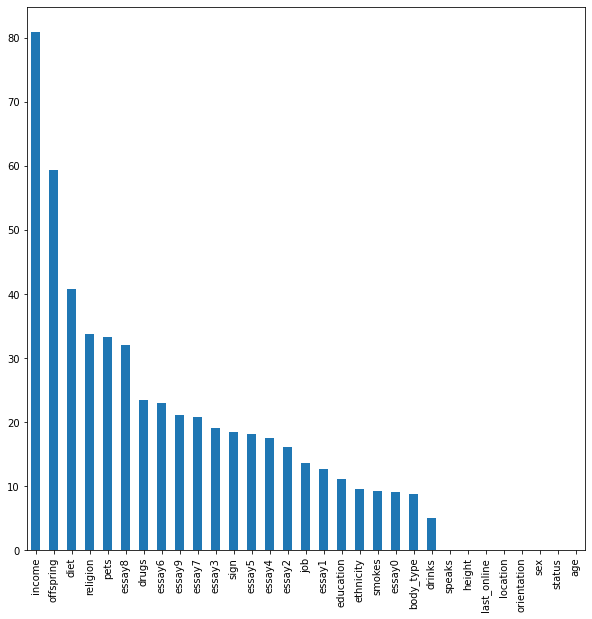

In [ ]:
df_nan = df.isna().mean().round(5)*100
df_nan['income'] = df[df['income']==-1].income.count() / 59946 * 100 # Calculamos el porcentaje de valores -1 de income
df_nan.sort_values(ascending=False).plot(kind='bar', figsize = [10, 10])

Como se puede observar, hay algunas columnas como offspring o diet que tienen un gran porcentaje de valores NaN. Para poder trabajar con estos datos, en vez de quitar estas columnas, se ha reemplazado el valor de NaN por "missing" y en las variables numéricas por -1.

In [ ]:
# Replace NaN for -1 in numeric columns
for col in df.select_dtypes(include= np.number):
  df[col].fillna(-1, inplace=True)

# Replace NaN for missing in non numeric columns
non_num_columns = set(df.columns.to_list()) - set(['age','height','income'])
for i in non_num_columns:
  df[i].fillna("missing", inplace=True)

print("Porcentaje de NaN\n")
df.isna().mean().round(5)*100

Porcentaje de NaN



age            0.0
status         0.0
sex            0.0
orientation    0.0
body_type      0.0
diet           0.0
drinks         0.0
drugs          0.0
education      0.0
ethnicity      0.0
height         0.0
income         0.0
job            0.0
last_online    0.0
location       0.0
offspring      0.0
pets           0.0
religion       0.0
sign           0.0
smokes         0.0
speaks         0.0
essay0         0.0
essay1         0.0
essay2         0.0
essay3         0.0
essay4         0.0
essay5         0.0
essay6         0.0
essay7         0.0
essay8         0.0
essay9         0.0
dtype: float64

## EDA

### Numerical variables

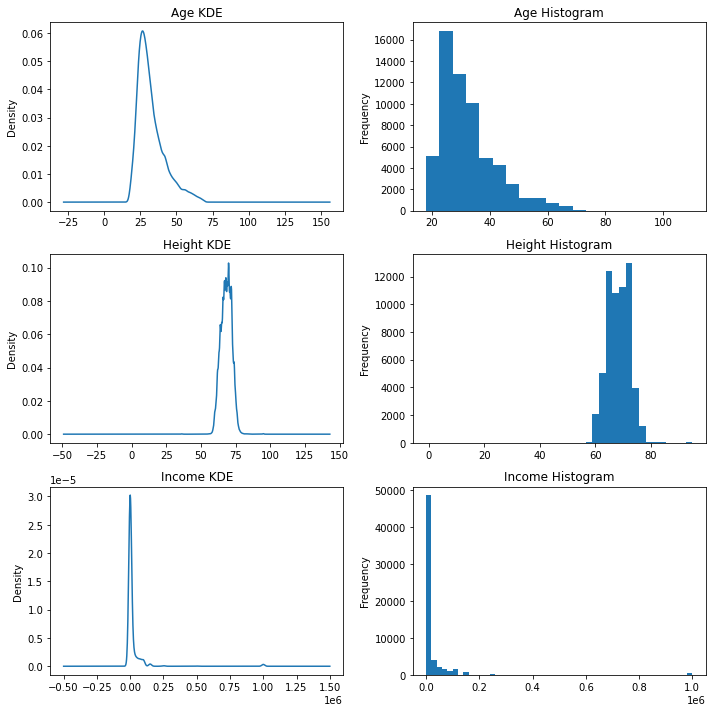

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2)

df['age'].plot(kind='kde', ax = axes[0][0], figsize=[10,10], title="Age KDE")
df['age'].plot(kind='hist', bins=20, ax = axes[0][1], figsize=[10,10], title="Age Histogram")

df['height'].plot(kind='kde', ax = axes[1][0], figsize=[10,10], title="Height KDE")
df['height'].plot(kind='hist', bins=40, ax = axes[1][1], figsize=[10,10],title="Height Histogram")

df['income'].plot(kind='kde', ax = axes[2][0], figsize=[10,10], title="Income KDE")
df['income'].plot(kind='hist', bins=50, ax = axes[2][1], figsize=[10,10], title="Income Histogram")

plt.tight_layout()

### Age

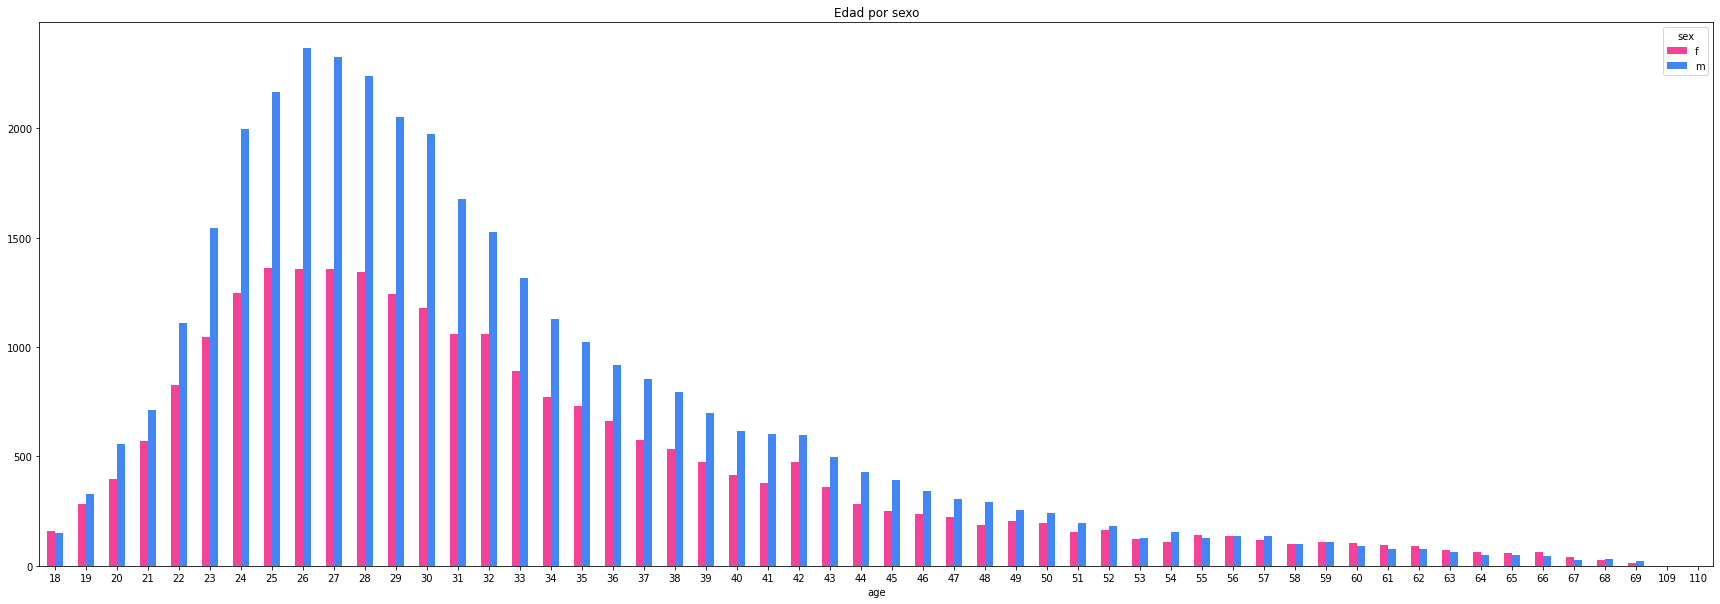

In [ ]:
colors = ["#f54298","#4287f5"]

age = df.groupby('sex')['age'].value_counts(sort='True')
age = age.unstack().transpose()

age.plot(kind='bar', color = colors,
               figsize = [30,10], rot = 0, title='Edad por sexo')

As we can see in the graph there are two outlayers whose age are 109 and 110 respectively.

In [ ]:
df.loc[df['age'] > 69]

age     status sex orientation  ...   essay6   essay7   essay8   essay9
2512   110     single   f    straight  ...  missing  missing  missing  missing
25324  109  available   m    straight  ...  missing  missing  missing  missing

[2 rows x 31 columns]

We delete this rows:

In [ ]:
df.drop(df[df.age > 69].index, inplace=True)

Once we have deleted the outlayers we can make different groups according to the age of the users.

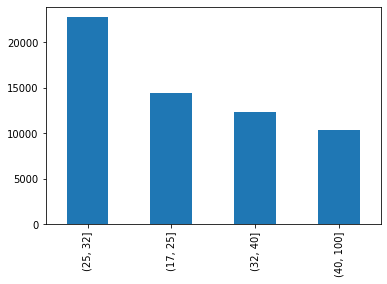

In [ ]:
df['age_group']=pd.cut(x=df['age'], bins=[17,25,32,40, 100])
df['age_group'].value_counts().plot(kind='bar')

In [ ]:
df.drop(columns=['age'], axis=1, inplace=True)

### Height

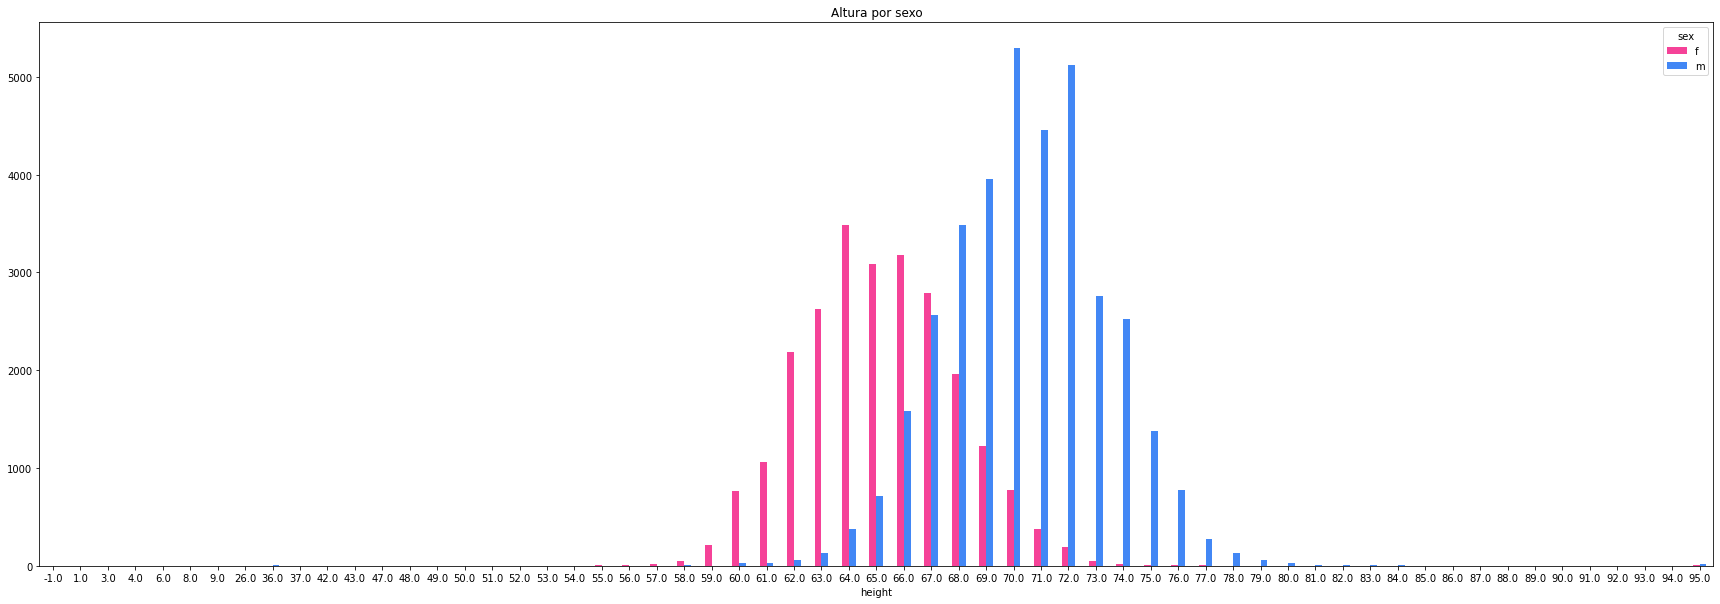

In [ ]:
height = df.groupby('sex')['height'].value_counts(sort='True')
height = height.unstack().transpose()

height.plot(kind='bar', color = colors,
               figsize = [30,10], rot = 0, title='Altura por sexo')

As we can see, the height variable follows a normal distribution for male and female.

Moreover, we can see that there are also outlayers in this variable that we can remove.

In [ ]:
df.loc[df['height'] < 54].shape[0]

39

In [ ]:
df.loc[df['height'] > 84].shape[0]

34

In [ ]:
df.drop(df[df.height < 54].index, inplace=True)
df.drop(df[df.height > 84].index, inplace=True)

As we did with the age, we can divide people according to their height in different groups.

In [ ]:
df['height_type'] = df.apply(lambda row:
                             'tall'
                              if (row['sex'] == 'm' and row['height']>=73) or (row['sex'] == 'f' and row['height']>=68)
                              else ('medium' 
                                    if(row['sex'] == 'm' and (row['height'] < 73 and row['height'] > 67)) or (row['sex'] == 'f' and (row['height'] < 68 and row['height'] > 63))
                                     else 'short'), axis=1)

In [ ]:
df.drop(columns=['height'], axis=1, inplace=True)

### Income

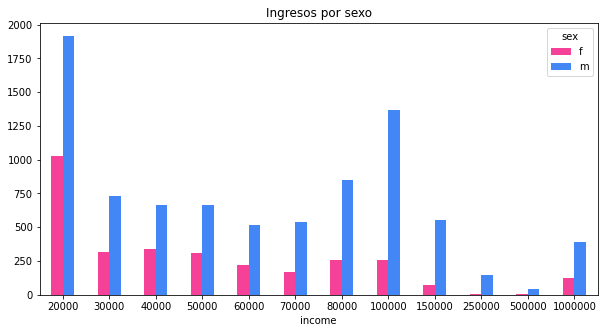

In [ ]:
income = df.groupby('sex')['income'].value_counts(sort='True')
income = income.unstack().transpose()
income[1:].plot(kind='bar', color = colors,
               figsize = [10,5], rot = 0, title='Ingresos por sexo') # drop -1 income values

### Categorical variables

In [ ]:
categorical = """status
sex
orientation
body_type
diet
drinks
drugs
education
ethnicity
job
last_online
location
offspring
pets
religion
sign
smokes
speaks"""

categorical = categorical.split('\n')

for col in categorical:
  print(df[col].value_counts(),'\n\n','='*50,'\n')

single            55628
seeing someone     2062
available          1862
married             309
unknown              10
Name: status, dtype: int64 


m    35780
f    24091
Name: sex, dtype: int64 


straight    51537
gay          5570
bisexual     2764
Name: orientation, dtype: int64 


average           14645
fit               12704
athletic          11807
missing            5277
thin               4709
curvy              3920
a little extra     2628
skinny             1777
full figured       1009
overweight          442
jacked              409
used up             347
rather not say      197
Name: body_type, dtype: int64 


missing                24354
mostly anything        16570
anything                6181
strictly anything       5109
mostly vegetarian       3442
mostly other            1002
strictly vegetarian      875
vegetarian               666
strictly other           447
mostly vegan             338
other                    331
strictly vegan           228
vegan              

#### Personal data

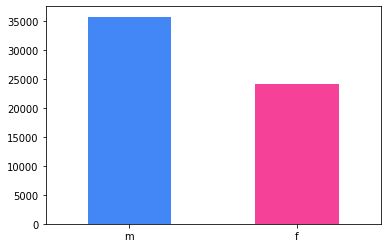

In [ ]:
df['sex'].value_counts().plot(kind='bar',rot=0, color=[colors[1],colors[0]])

It seems that the app is more popular among men.

In [ ]:
def print_column_by_gender(column_name):
  tmp = df.groupby('sex')[column_name].value_counts()
  tmp = tmp.unstack().transpose()
  tmp['total'] = tmp['m']+tmp['f']
  tmp.sort_values(by=['total'], ascending=False, inplace=True)
  tmp.drop(columns=['total'], inplace=True)
  tmp.plot(kind='bar', color = colors, figsize = [10,5], rot = 90, stacked=True)

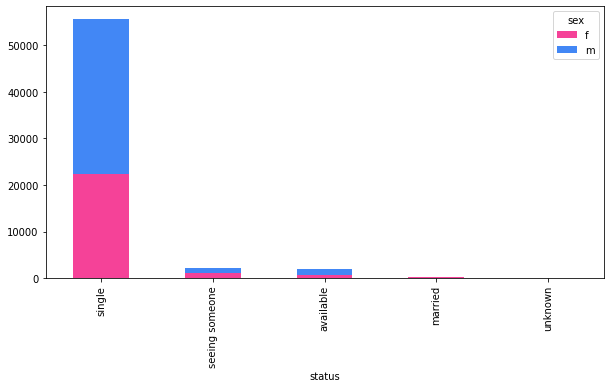

In [ ]:
print_column_by_gender('status')

We can delete the rows that have 'unknown' as the status.

In [ ]:
df.loc[df['status'] == 'unknown'].shape[0]

10

In [ ]:
df.drop(df[df.status == 'unknown'].index, inplace=True)

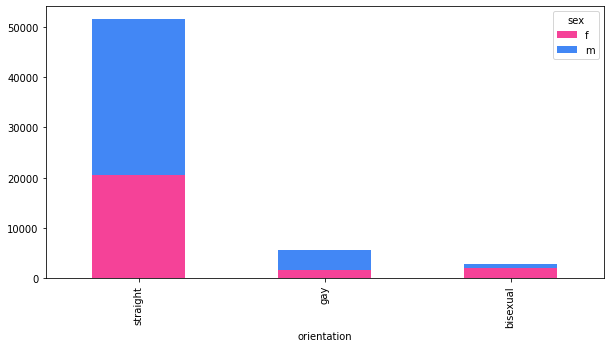

In [ ]:
print_column_by_gender('orientation')

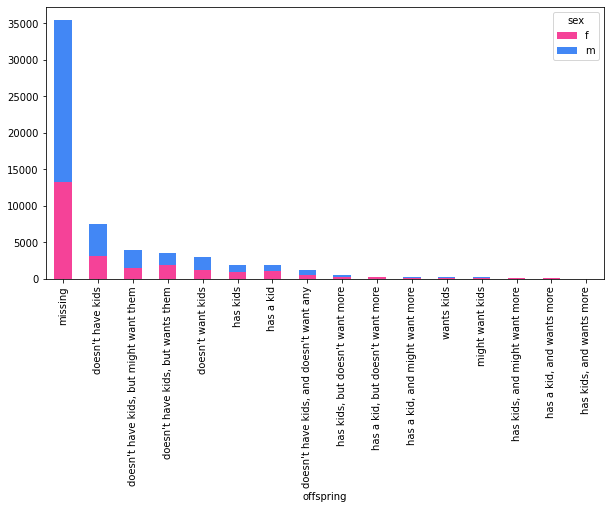

In [ ]:
print_column_by_gender('offspring')

We can divide the variable offspring in two different variables.

In [ ]:
df['has_kids'] = np.select([df['offspring'].str.contains("has"), df['offspring'].str.contains("doesn't have")], [1,-1], default=0)
df['wants_kids'] = np.select([df['offspring'].str.contains('wants|might want'), df['offspring'].str.contains("doesn't want")], [1,-1], default=0)

df.drop(columns=['offspring'], axis=1, inplace=True)
df

status sex orientation  ... height_type has_kids wants_kids
0         single   m    straight  ...        tall       -1          1
1         single   m    straight  ...      medium       -1          1
2      available   m    straight  ...      medium        0          0
3         single   m    straight  ...      medium        0         -1
4         single   m    straight  ...       short        0          0
...          ...  ..         ...  ...         ...      ...        ...
59941     single   f    straight  ...       short        1          0
59942     single   m    straight  ...      medium       -1          0
59943     single   m    straight  ...      medium       -1          0
59944     single   m    straight  ...        tall       -1          1
59945     single   m         gay  ...      medium        0          0

[59861 rows x 32 columns]

We can see the results in the following graph:

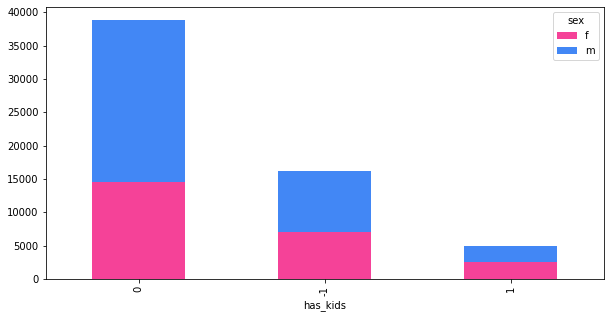

In [ ]:
print_column_by_gender('has_kids')

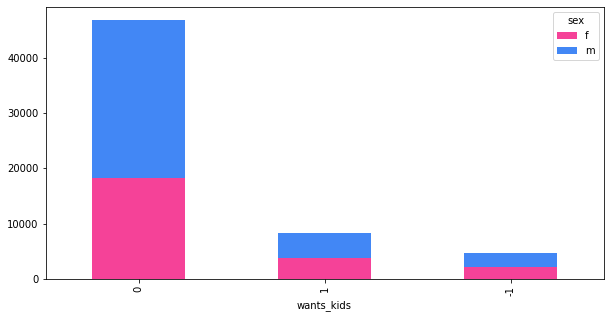

In [ ]:
print_column_by_gender('wants_kids')

In [ ]:
location = df['location'].str.split(', ', 1, expand=True)
location.rename(columns={0:'city', 1:'state/country'},inplace=True)
location

city state/country
0      south san francisco    california
1                  oakland    california
2            san francisco    california
3                 berkeley    california
4            san francisco    california
...                    ...           ...
59941              oakland    california
59942        san francisco    california
59943  south san francisco    california
59944        san francisco    california
59945        san francisco    california

[59861 rows x 2 columns]

#### Location

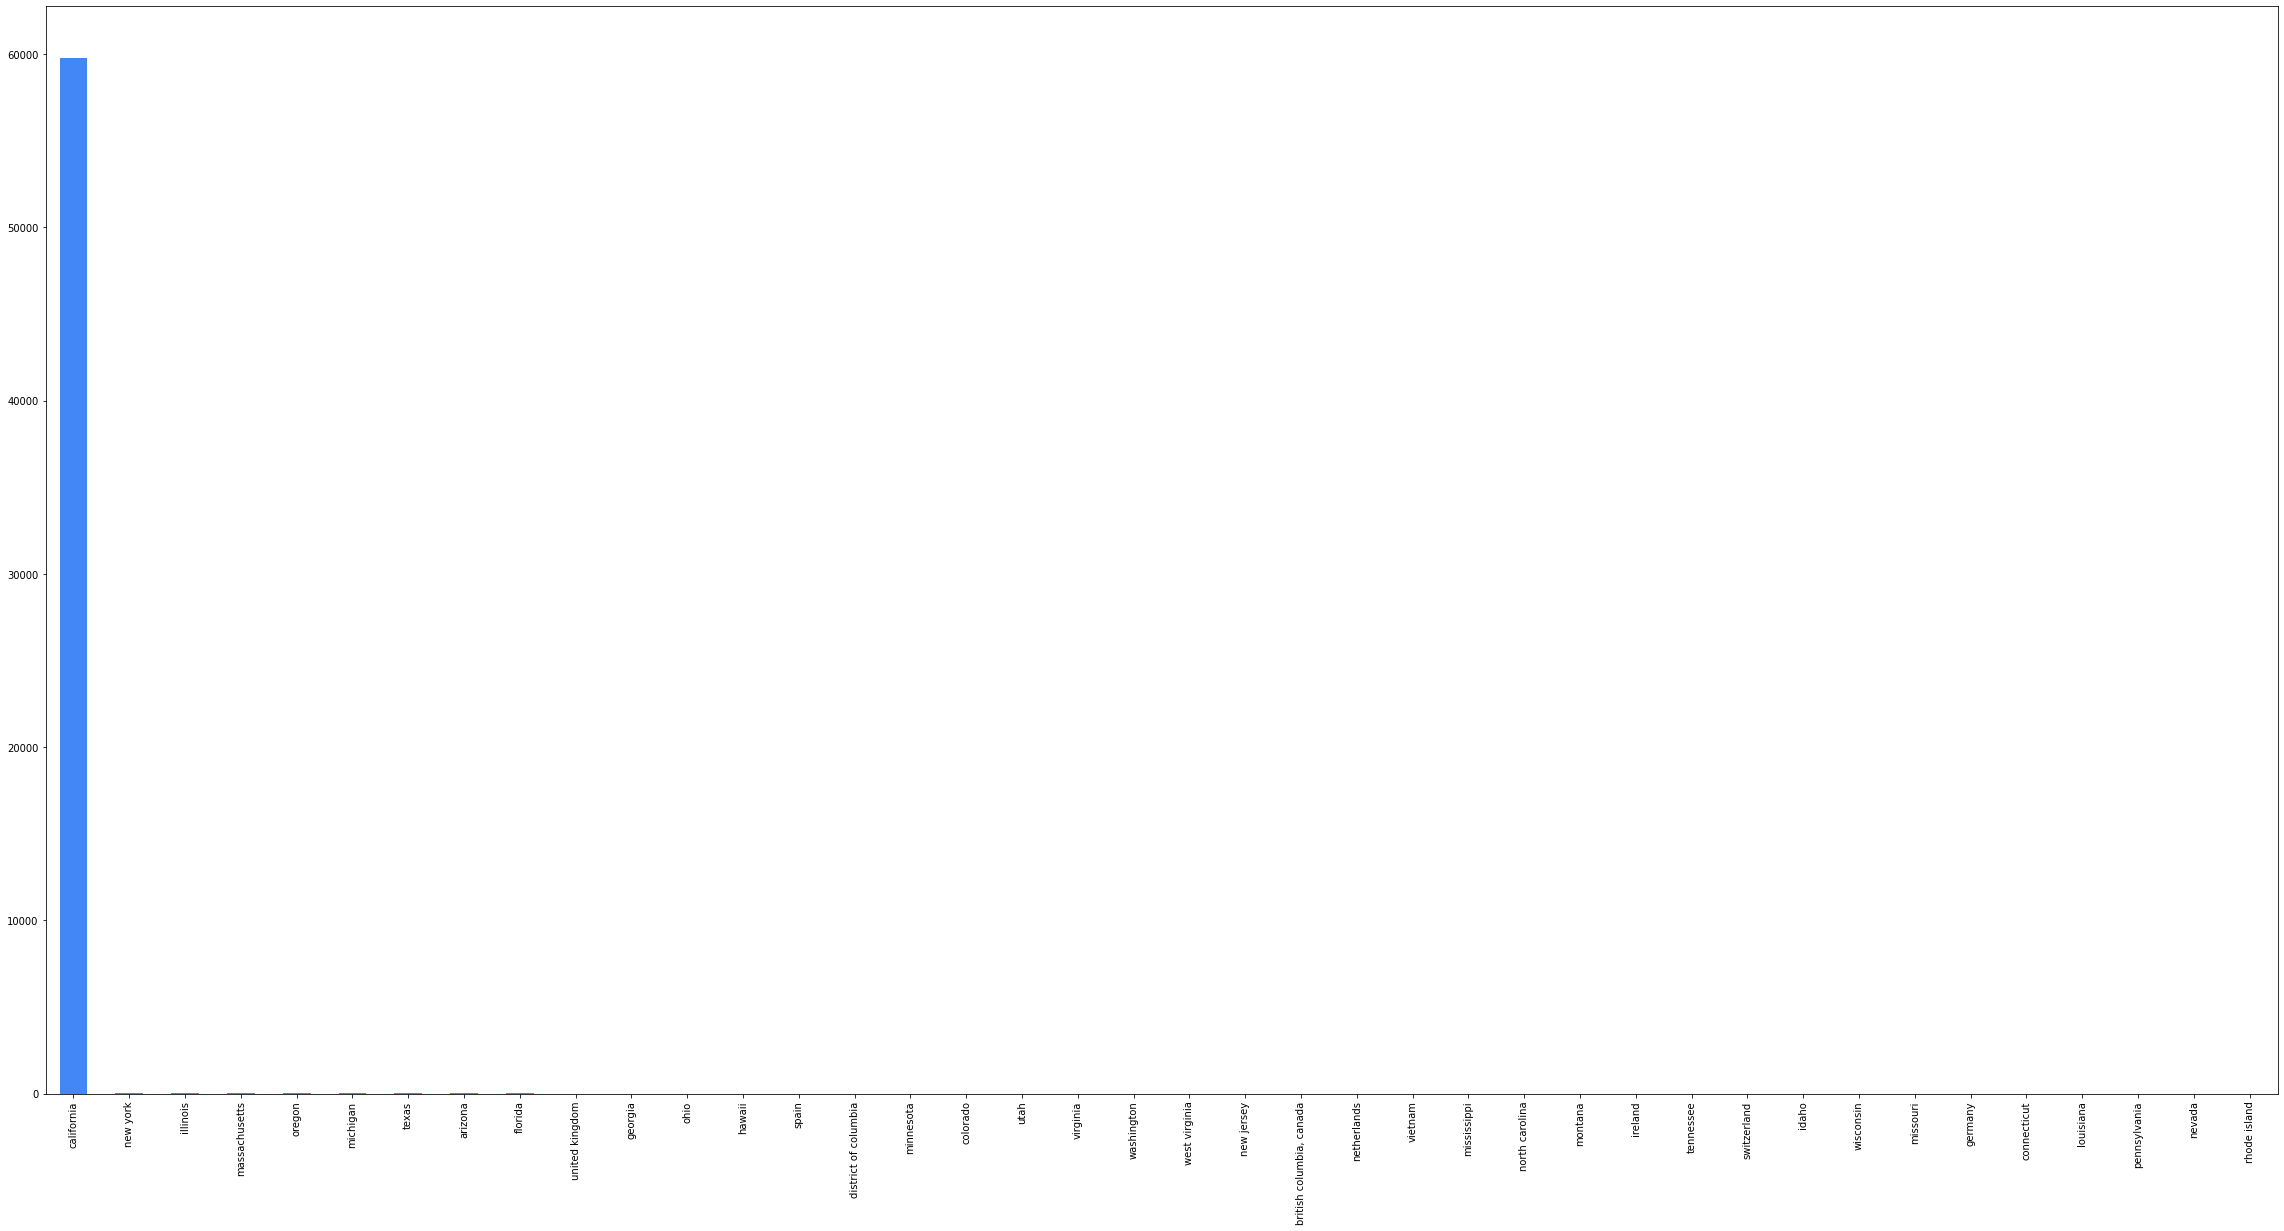

In [ ]:
location['state/country'].value_counts().plot(kind='bar',rot= 90, figsize= [40,20], color=colors[1])

We can see that the app is quite popular among users that are from California.

In [ ]:
df.loc[df['location'].str.contains('california') == False].shape[0]

90

In [ ]:
df.drop(df[df['location'].str.contains('california') == False].index, inplace=True)

As we have dropped the places that are not from California, we can add another column that contains the city of the user.

In [ ]:
df['city'] = df['location'].str.split(',', expand=True)[0]
df['city']

0        south san francisco
1                    oakland
2              san francisco
3                   berkeley
4              san francisco
                ...         
59941                oakland
59942          san francisco
59943    south san francisco
59944          san francisco
59945          san francisco
Name: city, Length: 59771, dtype: object

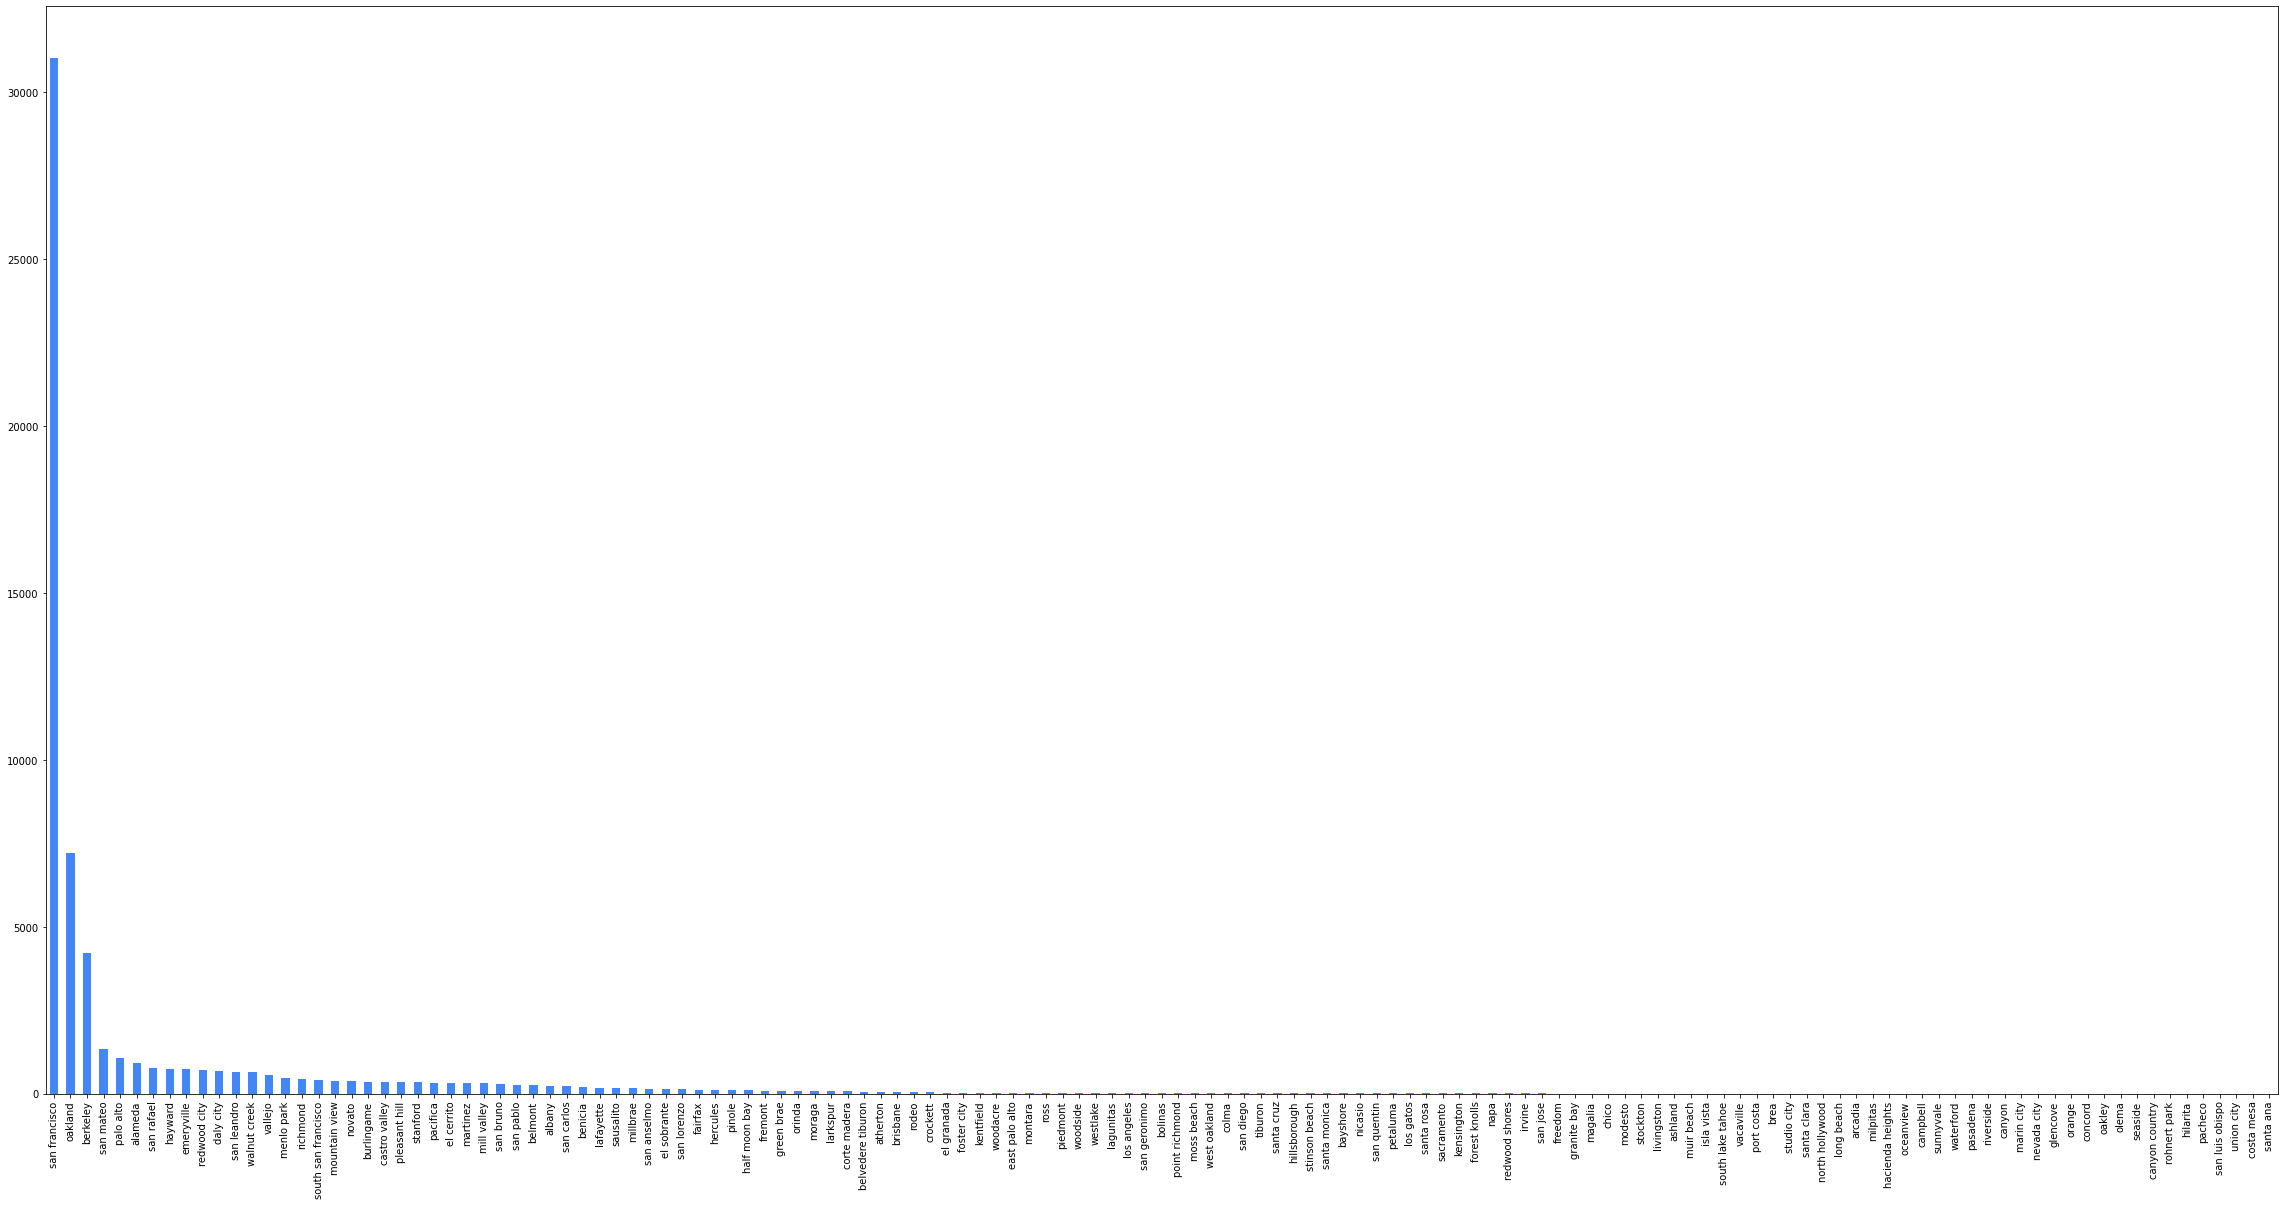

In [ ]:
df['city'].value_counts().plot(kind='bar',rot= 90, figsize= [40,20], color=colors[1])

There are a lot of cities among the dataset. We can see that not all the cities have the same amount of users. 

We decided to drop cities whose number of users where below 100.

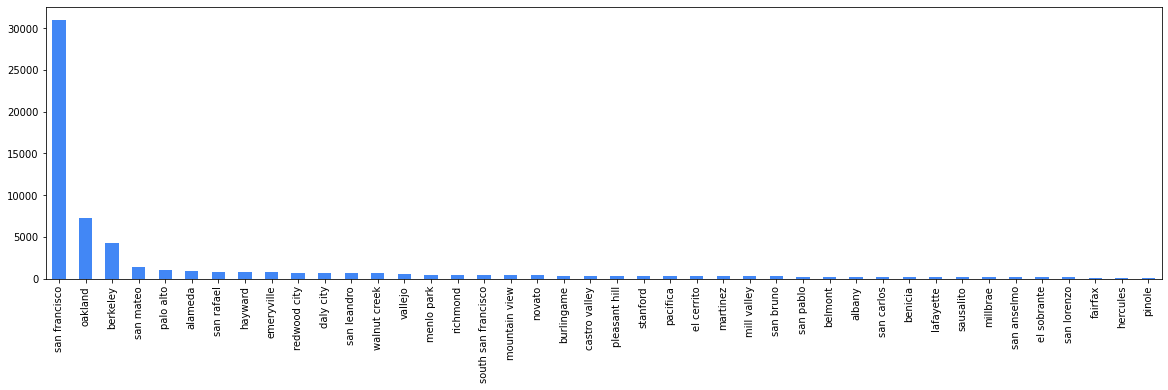

In [ ]:
df = df[df.groupby('city').city.transform('count') > 100]
df['city'].value_counts().plot(kind='bar', rot= 90, figsize= [20,5], color=colors[1])

In [ ]:
df.drop(columns=['location'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Healthy habits

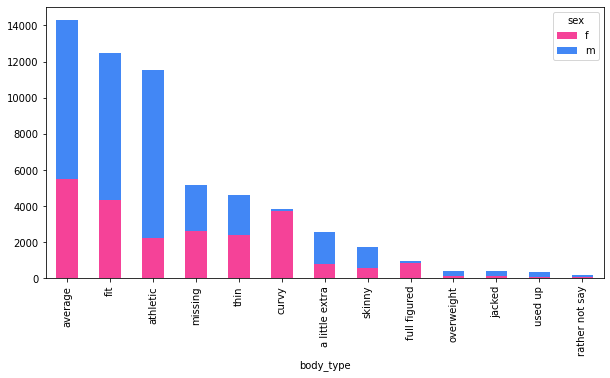

In [ ]:
print_column_by_gender('body_type')

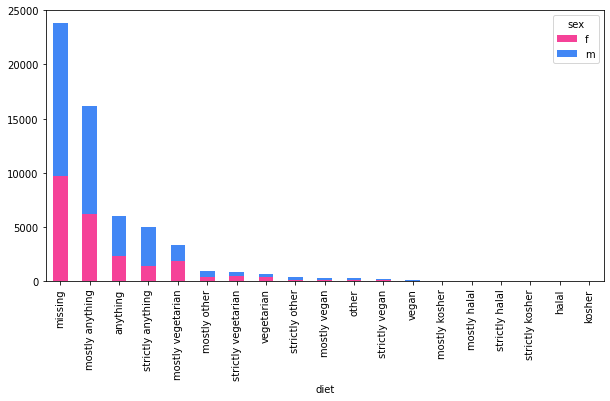

In [ ]:
print_column_by_gender('diet')

We can remove halal and kosher diets since just a few users follow these diets.

In [ ]:
df.loc[df['diet'].str.contains('kosher|halal')].shape[0]

188

In [ ]:
df.drop(df[df['diet'].str.contains('kosher|halal')].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


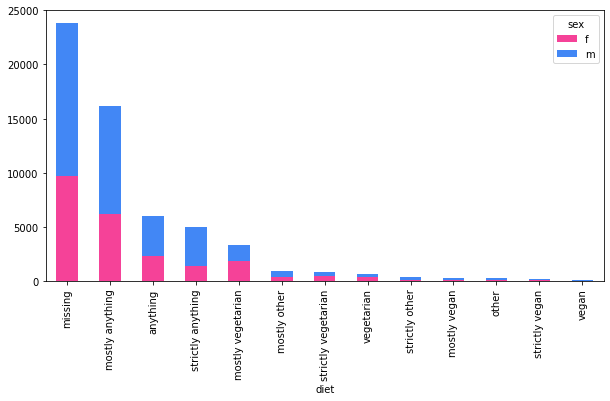

In [ ]:
print_column_by_gender('diet')

We can also group the diets dispite the modifier that the users answered.

In [ ]:
df['diet'] = np.select([df['diet'].str.contains("anything"), df['diet'].str.contains("vegetarian"),
                        df['diet'].str.contains("vegan"), df['diet'].str.contains("other"), 
                        df['diet'].str.contains("missing")],
                       ["anything","vegetarian", "vegan", "other", "missing"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


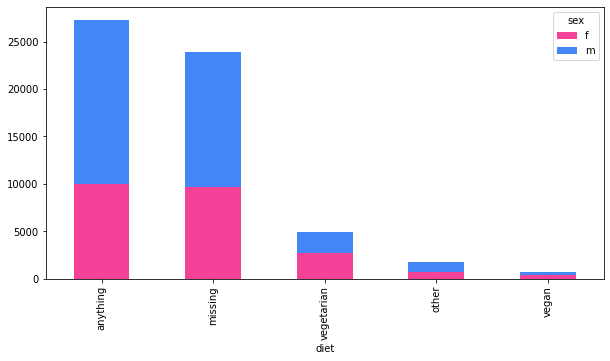

In [ ]:
print_column_by_gender('diet')

#### Adictions

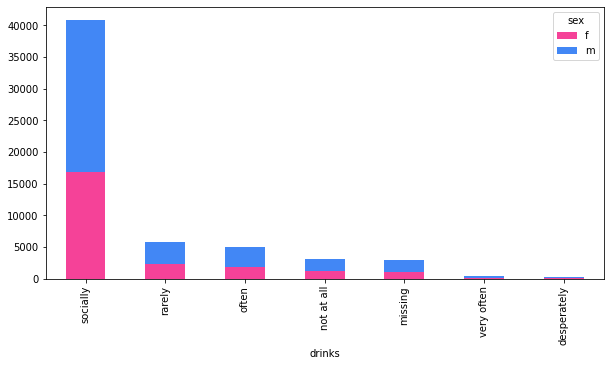

In [ ]:
print_column_by_gender('drinks')

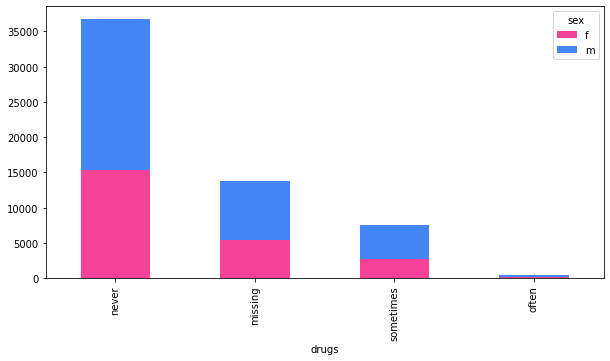

In [ ]:
print_column_by_gender('drugs')

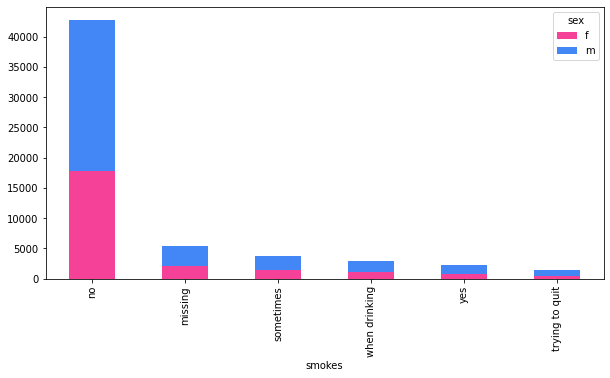

In [ ]:
print_column_by_gender('smokes')

#### Careers

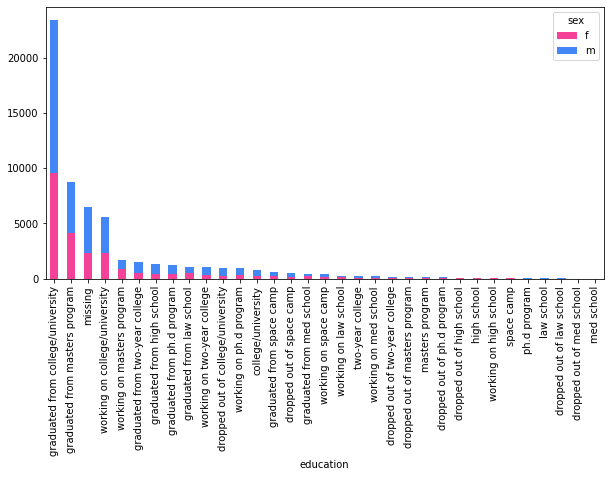

In [ ]:
print_column_by_gender('education')

We can use a Count Vectorizer to deal with the 'education' variable in a better way.

In [ ]:
education_vect = CountVectorizer(stop_words=['on','out', 'of','from','missing', 'program', 'camp', 'university', 'school', 'year'])
education = education_vect.fit_transform(df['education'])
education_df = pd.DataFrame(education.toarray(), columns=education_vect.get_feature_names())
education_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df = pd.concat([df, education_df], axis=1)

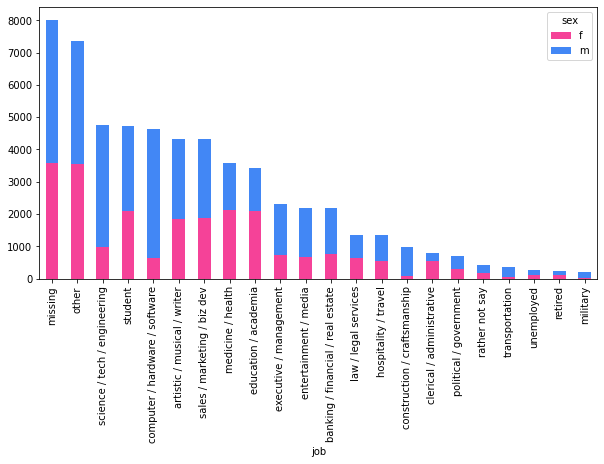

In [ ]:
print_column_by_gender('job')

Apparently most of OkCupid users jobs don't fit among the categories that the app provides. We can highlight the big difference in the number of males and females in the tech and software environments.

#### Pets

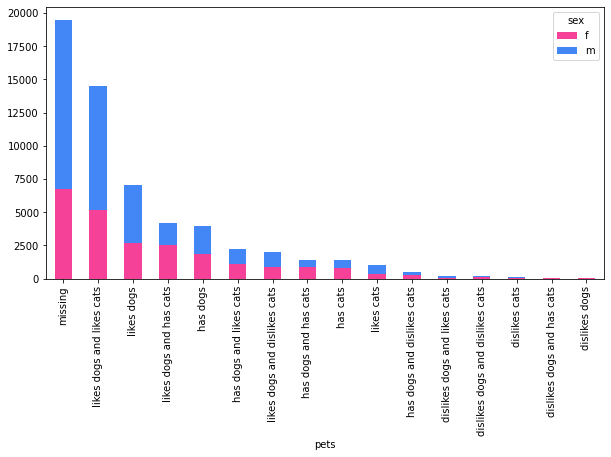

In [ ]:
print_column_by_gender('pets')

We can divide this column in order to know whether a person likes dogs, cats or both.

In [ ]:
df['likes_dogs'] = np.select([df['pets'].str.contains("dislikes dogs"), df['pets'].str.contains("likes dogs")], [-1,1], default=0)
df['likes_cats'] = np.select([df['pets'].str.contains("dislikes cats"), df['pets'].str.contains("likes cats")], [-1,1], default=0)

df['has_dogs'] = np.select([df['pets'].str.contains("has dogs")], [1], default=0)
df['has_cats'] = np.select([df['pets'].str.contains("has cats")], [1], default=0)

In [ ]:
df.drop(columns=['pets'], axis=1, inplace=True)

#### Religion and sign

For the religion variable we need to split this one into two different columns.

In [ ]:
religion = df['religion'].str.split(' ', 1, expand=True)
religion.rename(columns= {0:'religion', 1:'religion_importance'}, inplace=True)
religion.tail(10)

religion           religion_importance
58442       atheism                          None
58443       judaism         and laughing about it
58444         other                          None
58445       missing                          None
58446   agnosticism                          None
58447   catholicism  but not too serious about it
58448   agnosticism                          None
58449  christianity  but not too serious about it
58450   agnosticism  but not too serious about it
58451   catholicism         and laughing about it

In [ ]:
religion['religion_importance'].fillna("missing", inplace=True)
religion.describe()

religion religion_importance
count     58452               58452
unique       10                   5
top     missing             missing
freq      19804               31266

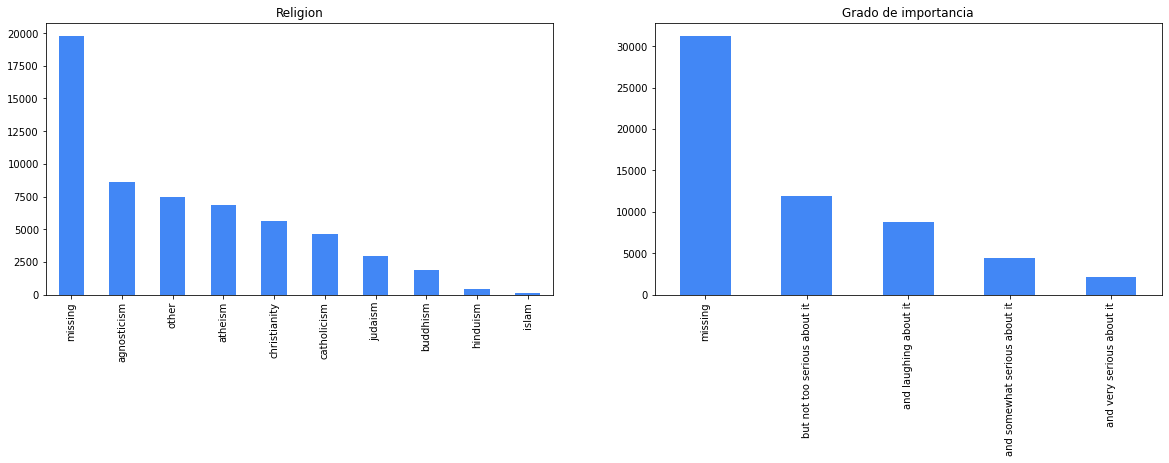

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
religion['religion'].value_counts().plot(kind='bar', ax=axes[0], color=colors[1], figsize = [20,5], title='Religion')
religion['religion_importance'].value_counts().plot(kind='bar', ax=axes[1], color=colors[1], figsize = [20,5], title='Grado de importancia')

We do the same with the sign variable: 

In [ ]:
sign = df['sign'].str.split(' ', 1, expand=True)
sign.rename(columns= {0:'horoscope_sign', 1:'sign_importance'}, inplace=True)
sign.tail(10)

horoscope_sign                    sign_importance
58442          virgo        but it doesn&rsquo;t matter
58443        missing                               None
58444            leo  and it&rsquo;s fun to think about
58445         pisces  and it&rsquo;s fun to think about
58446    sagittarius                               None
58447         cancer  and it&rsquo;s fun to think about
58448            leo        but it doesn&rsquo;t matter
58449    sagittarius        but it doesn&rsquo;t matter
58450            leo  and it&rsquo;s fun to think about
58451         gemini  and it&rsquo;s fun to think about

In [ ]:
sign['sign_importance'].fillna("missing", inplace=True)
sign.describe()

horoscope_sign sign_importance
count           58452           58452
unique             13               4
top           missing         missing
freq            10797           22614

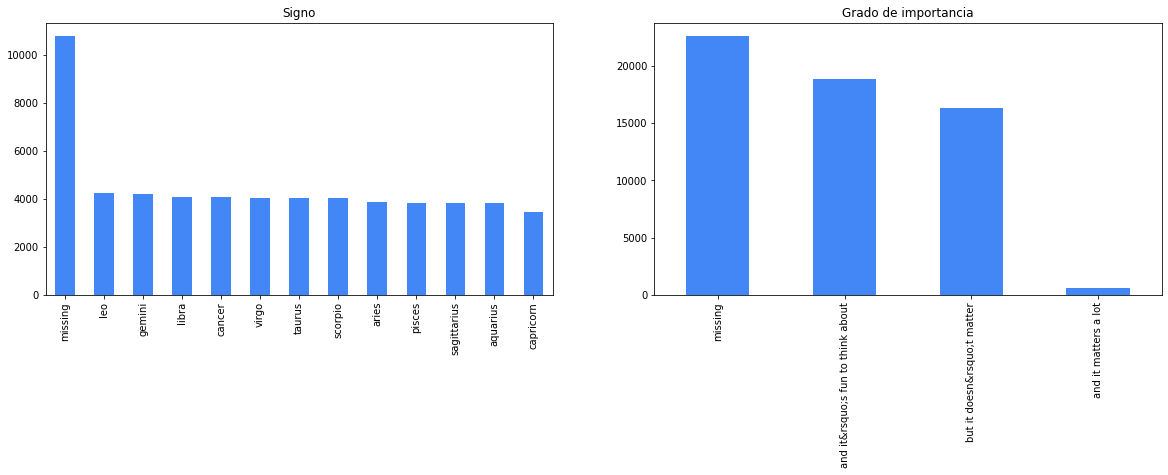

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
sign['horoscope_sign'].value_counts().plot(kind='bar', ax=axes[0], color=colors[1], figsize = [20,5], title='Signo')
sign['sign_importance'].value_counts().plot(kind='bar', ax=axes[1], color=colors[1], figsize = [20,5], title='Grado de importancia')

### Text variables

'ethinicity' and 'speaks' have a lot of categories that we can deal with using Count Vectorizer.

In [ ]:
count_vectorizer = CountVectorizer(stop_words=['missing'], token_pattern=r'(?u)\b\w\w+ ?\w+\b')

ethnicity = count_vectorizer.fit_transform(df['ethnicity'])
df_eth = pd.DataFrame(ethnicity.toarray(), columns=count_vectorizer.get_feature_names())
df_eth

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


asian  black  hispanic  ...  other  pacific islander  white
0          1      0         0  ...      0                 0      1
1          0      0         0  ...      0                 0      1
2          0      0         0  ...      0                 0      0
3          0      0         0  ...      0                 0      1
4          1      1         0  ...      1                 0      0
...      ...    ...       ...  ...    ...               ...    ...
58447      0      0         0  ...      0                 0      0
58448      0      0         0  ...      1                 0      1
58449      1      0         0  ...      0                 0      0
58450      1      1         0  ...      0                 0      0
58451      0      0         0  ...      0                 0      1

[58452 rows x 10 columns]

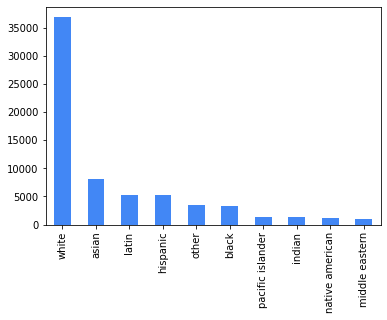

In [ ]:
df_eth.sum().sort_values(ascending=False).plot(kind='bar', color=colors[1])

In [ ]:
count_vectorizer = CountVectorizer(stop_words=['poorly','okay','fluently', 'other', 'language','missing'])

speaks = count_vectorizer.fit_transform(df['speaks'])
df_spe = pd.DataFrame(speaks.toarray(), columns=count_vectorizer.get_feature_names())
df_spe

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


afrikaans  albanian  ancient  arabic  ...  urdu  vietnamese  welsh  yiddish
0              0         0        0       0  ...     0           0      0        0
1              0         0        0       0  ...     0           0      0        0
2              0         0        0       0  ...     0           0      0        0
3              0         0        0       0  ...     0           0      0        0
4              0         0        0       0  ...     0           0      0        0
...          ...       ...      ...     ...  ...   ...         ...    ...      ...
58447          0         0        0       0  ...     0           0      0        0
58448          0         0        0       0  ...     0           0      0        0
58449          0         0        0       0  ...     0           0      0        0
58450          0         0        0       0  ...     0           0      0        0
58451          0         0        0       0  ...     0           0      0        0

[58452 rows x 75 columns]

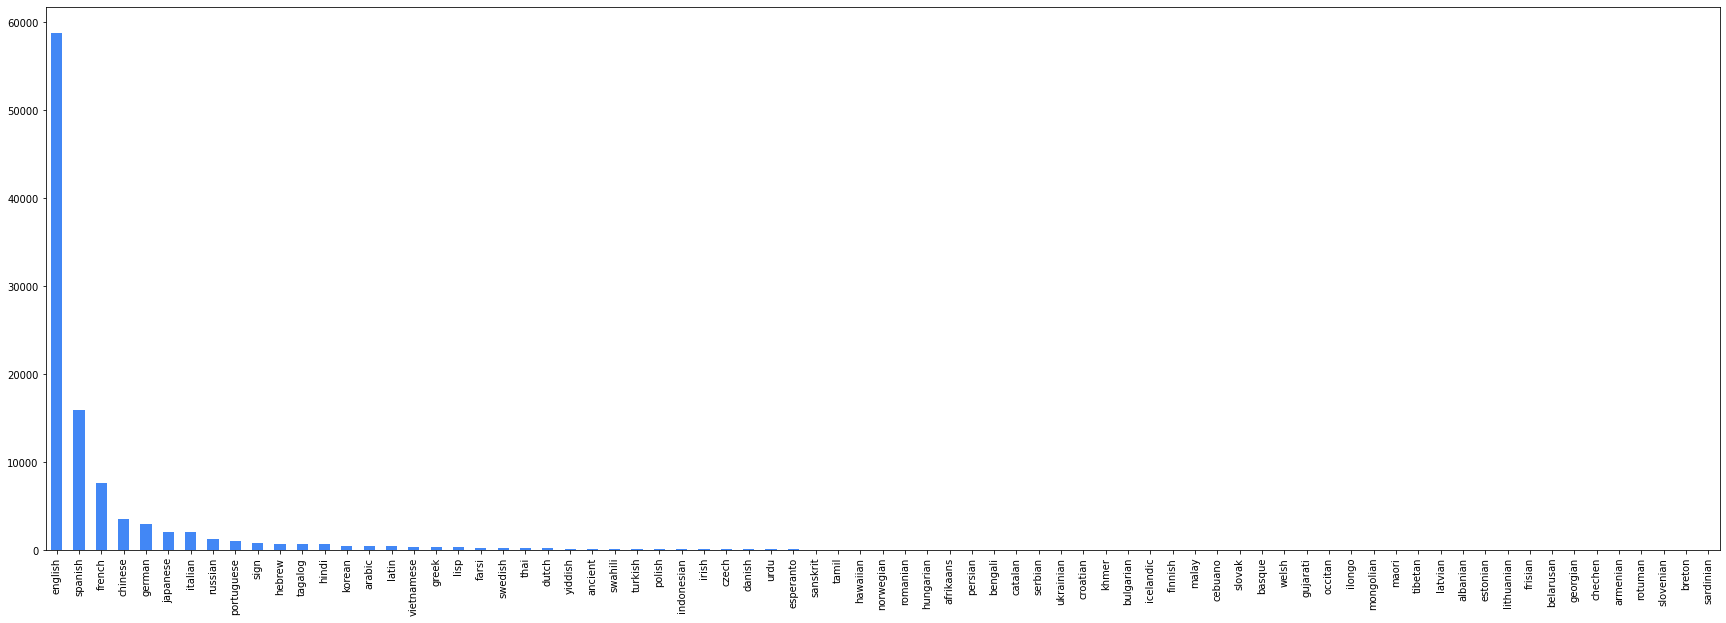

In [ ]:
df_spe.sum().sort_values(ascending=False).plot(kind='bar', figsize=[30,10], color=colors[1])

In order to deal with the essays we can use NLTK which is a library to deal with text variables.

In [ ]:
nltk.download("popular")
english_stopwords = stopwords.words('english')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [ ]:
df[['essay0']].iloc[0,0]

"about me:  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes.  about you:  you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and tele

As we can see, the text has a lot of information that is not relevant for our analysis so we need to clean first.

In [ ]:
tokens = word_tokenize(df[['essay0']].iloc[0,0])

# convert to lower case
tokens = [w.lower() for w in tokens]

# remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]

# filter out stop words
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]

# lemmatizing
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in words]

print(lemmatized)

['would', 'love', 'think', 'kind', 'intellectual', 'either', 'dumbest', 'smart', 'guy', 'smartest', 'dumb', 'guy', 'ca', 'nt', 'say', 'tell', 'difference', 'love', 'talk', 'idea', 'concept', 'forge', 'odd', 'metaphor', 'instead', 'reciting', 'cliche', 'like', 'simularities', 'friend', 'mine', 'house', 'underwater', 'salt', 'mine', 'favorite', 'word', 'salt', 'way', 'weird', 'choice', 'know', 'thing', 'life', 'better', 'metaphor', 'seek', 'make', 'little', 'better', 'everyday', 'productively', 'lazy', 'way', 'got', 'tired', 'tying', 'shoe', 'considered', 'hiring', 'five', 'year', 'old', 'would', 'probably', 'tie', 'shoe', 'decided', 'wear', 'leather', 'shoe', 'dress', 'shoe', 'love', 'really', 'serious', 'really', 'deep', 'conversation', 'really', 'silly', 'stuff', 'willing', 'snap', 'light', 'hearted', 'rant', 'kiss', 'nt', 'funny', 'able', 'make', 'laugh', 'able', 'bend', 'spoon', 'mind', 'telepathically', 'make', 'smile', 'still', 'work', 'love', 'life', 'cool', 'letting', 'wind', 'b

## Preprocessing

In [ ]:
X = df.copy()

X.drop(['sign','religion', 'ethnicity','speaks'], inplace=True, axis=1)
X = pd.concat([X, sign, religion], axis=1)
X

status sex  ...      religion           religion_importance
0         single   m  ...   agnosticism     and very serious about it
1         single   m  ...   agnosticism  but not too serious about it
2      available   m  ...       missing                       missing
3         single   m  ...       missing                       missing
4         single   m  ...       missing                       missing
...          ...  ..  ...           ...                           ...
58447     single   f  ...   catholicism  but not too serious about it
58448     single   m  ...   agnosticism                       missing
58449     single   m  ...  christianity  but not too serious about it
58450     single   m  ...   agnosticism  but not too serious about it
58451     single   m  ...   catholicism         and laughing about it

[58452 rows x 46 columns]

#### Text preprocessing

In order to preprocess the text we are going to join all the essay fields and then apply tf-idf Vectorizer.

In [ ]:
X['essays'] = ''
essay_names = X.loc[:,'essay0':'essay9']

for essay_name in essay_names:
    X['essays'] = X['essays'] +' ' +  X[essay_name]

X['essays'] = X['essays'].replace('missing', '')

X['essays']

0         about me:  i would love to think that i was s...
1         i am a chef: this is what that means. 1. i am...
2         i'm not ashamed of much, but writing public t...
3         i work in a library and go to school. . . rea...
4         hey how's it going? currently vague on the pr...
                               ...                        
58447     vibrant, expressive, caring optimist. i love ...
58448     i'm nick. i never know what to write about my...
58449     hello! i enjoy traveling, watching movies, an...
58450     "all i have in this world are my balls and my...
58451     is it odd that having a little "enemy" status...
Name: essays, Length: 58452, dtype: object

In [ ]:
X[['essays']].iloc[0,0]

" about me:  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes.  about you:  you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and tel

Once our text is assembled into one variable we need to clean the text:

* Lowercase the text
* Remove punctuacion symbols
* Remove non alphabetical characters
* Filter out stop words
* Apply lemmatizing

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
  tokens = word_tokenize(text)
  
  # remove remaining tokens that are not alphabetic
  tokens = [token for token in tokens if token.isalpha()]
  
  # convert to lower case
  tokens = [w.lower() for w in tokens]
  
  # filter out stop words
  words = [w for w in tokens if not w in stop_words]
  
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  
  words = [w.translate(table) for w in words]
  
  # lemmatizing
  lemmatizer = WordNetLemmatizer()
  lemmatized = [lemmatizer.lemmatize(word) for word in words]

  return lemmatized

In [ ]:
tf_idf = TfidfVectorizer(tokenizer=clean_text, 
                         strip_accents='ascii',
                         min_df = 0.03, max_df = 0.5)

transformed_essays = tf_idf.fit_transform(X['essays'])
transformed_essays

<58452x937 sparse matrix of type '<class 'numpy.float64'>'
	with 4917020 stored elements in Compressed Sparse Row format>

We can create another dataframe that contains the relevant words from the essays.

In [ ]:
words = pd.DataFrame.sparse.from_spmatrix(transformed_essays, columns=tf_idf.get_feature_names())
words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


ability      able  absolutely  ...  yoga      york     young
0          0.0  0.170148         0.0  ...   0.0  0.000000  0.000000
1          0.0  0.000000         0.0  ...   0.0  0.000000  0.000000
2          0.0  0.000000         0.0  ...   0.0  0.000000  0.061491
3          0.0  0.000000         0.0  ...   0.0  0.000000  0.000000
4          0.0  0.000000         0.0  ...   0.0  0.000000  0.000000
...        ...       ...         ...  ...   ...       ...       ...
58447      0.0  0.000000         0.0  ...   0.0  0.000000  0.000000
58448      0.0  0.000000         0.0  ...   0.0  0.000000  0.000000
58449      0.0  0.000000         0.0  ...   0.0  0.113291  0.000000
58450      0.0  0.000000         0.0  ...   0.0  0.000000  0.000000
58451      0.0  0.000000         0.0  ...   0.0  0.000000  0.000000

[58452 rows x 937 columns]

##### Text visualization

In order to show which of the words are the most important we can display a word cloud diagram. However, first we need to know which words are the most important according to tf-idf. We define the following functions to do that:

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


In [ ]:
feature_names = tf_idf.get_feature_names()

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(transformed_essays.tocoo())

#extract only the top n; n here is 300
keywords=extract_topn_from_vector(feature_names,sorted_items, 300)
keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'adventure': 1.0,
 'alone': 1.0,
 'anything': 1.0,
 'appreciate': 0.887,
 'as': 0.982,
 'asian': 0.841,
 'ask': 0.84,
 'awesome': 0.986,
 'bang': 0.913,
 'basketball': 1.0,
 'beauty': 1.0,
 'bed': 1.0,
 'berkeley': 1.0,
 'best': 1.0,
 'brain': 1.0,
 'car': 0.849,
 'career': 1.0,
 'cat': 0.927,
 'check': 0.915,
 'cheese': 0.906,
 'climbing': 0.845,
 'coffee': 0.889,
 'college': 1.0,
 'come': 0.884,
 'coming': 1.0,
 'conversation': 1.0,
 'cooking': 1.0,
 'crazy': 0.886,
 'curious': 1.0,
 'date': 1.0,
 'different': 0.864,
 'dinner': 1.0,
 'drawing': 1.0,
 'drink': 0.841,
 'drinking': 0.868,
 'early': 0.892,
 'education': 1.0,
 'end': 1.0,
 'energy': 1.0,
 'english': 1.0,
 'enjoy': 0.911,
 'enjoyed': 1.0,
 'etc': 0.841,
 'ever': 1.0,
 'everything': 1.0,
 'exciting': 0.933,
 'eye': 1.0,
 'face': 0.859,
 'favorite': 0.954,
 'feel': 1.0,
 'find': 0.868,
 'fish': 0.871,
 'free': 1.0,
 'fresh': 1.0,
 'friendly': 0.841,
 'fun': 1.0,
 'funny': 0.838,
 'genre': 1.0,
 'give': 1.0,
 'go': 1.0,
 'go

Once we have the words, we create the cloud:

(-0.5, 599.5, 599.5, -0.5)

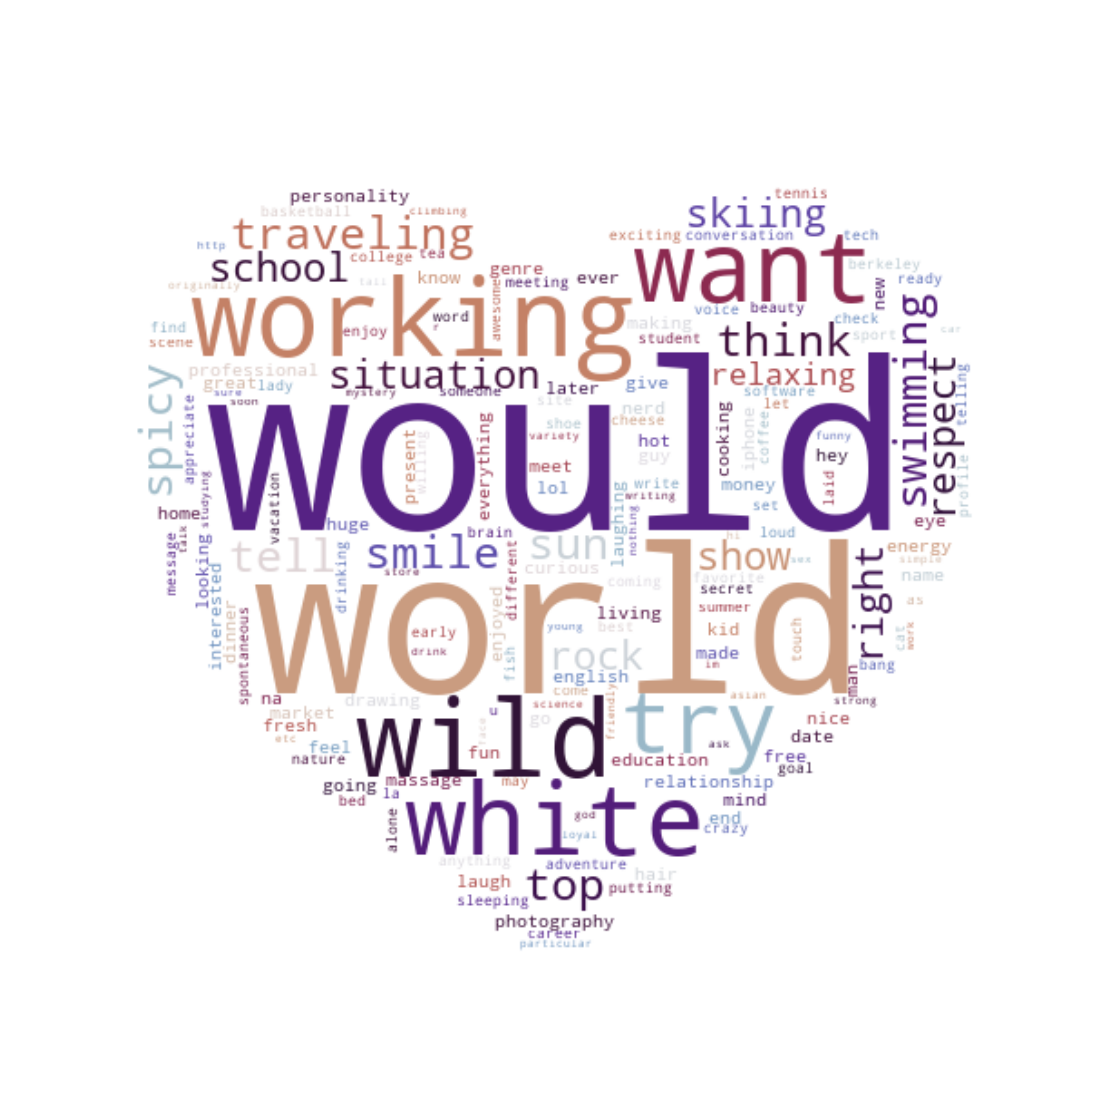

In [ ]:
r = requests.get('https://static8.depositphotos.com/1037178/856/v/600/depositphotos_8561241-stock-illustration-black-heart.jpg')

with open("heart.png", "wb") as file:
    file.write(r.content)
heart = Image.open("heart.png")

ok_cupid_mask = np.array(heart)

word_cloud = WordCloud(collocations=False, background_color = 'white',
                       mask=ok_cupid_mask, 
                       relative_scaling=0, colormap='twilight',
                       random_state=1337).generate_from_frequencies(keywords)

plt.figure(figsize=(20, 20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")

In [ ]:
X.drop(['essays'], inplace=True, axis=1)
X.drop(essay_names, inplace=True, axis=1)

### Transformers

In [ ]:
ct = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first'), ['sex']),
        ('ord', OrdinalEncoder(), ['age_group','status', 'orientation','height_type', 'body_type','diet', 
                                  'drinks', 'drugs', 'education', 'job',
                                  'smokes', 'horoscope_sign', 'sign_importance','religion',
                                  'religion_importance','city']),
        ('drop', 'drop', ['last_online'])
    ], remainder='passthrough')

transformed_X = ct.fit_transform(X)
transformed_X = pd.concat([pd.DataFrame(transformed_X), df_eth, df_spe], axis = 1)

final_X = pd.DataFrame(StandardScaler().fit_transform(transformed_X))

final_X = pd.concat([final_X, words], axis=1)

final_X

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0         1         2  ...  yoga      york     young
0      0.819824 -1.286949  0.245747  ...   0.0  0.000000  0.000000
1      0.819824  0.681847  0.245747  ...   0.0  0.000000  0.000000
2      0.819824  0.681847 -5.089558  ...   0.0  0.000000  0.061491
3      0.819824 -1.286949  0.245747  ...   0.0  0.000000  0.000000
4      0.819824 -0.302551  0.245747  ...   0.0  0.000000  0.000000
...         ...       ...       ...  ...   ...       ...       ...
58447 -1.219774  1.666245  0.245747  ...   0.0  0.000000  0.000000
58448  0.819824 -1.286949  0.245747  ...   0.0  0.000000  0.000000
58449  0.819824  1.666245  0.245747  ...   0.0  0.113291  0.000000
58450  0.819824 -0.302551  0.245747  ...   0.0  0.000000  0.000000
58451  0.819824  0.681847  0.245747  ...   0.0  0.000000  0.000000

[58452 rows x 1057 columns]

## Dataset visualization and dimensionality reduction

### PCA

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


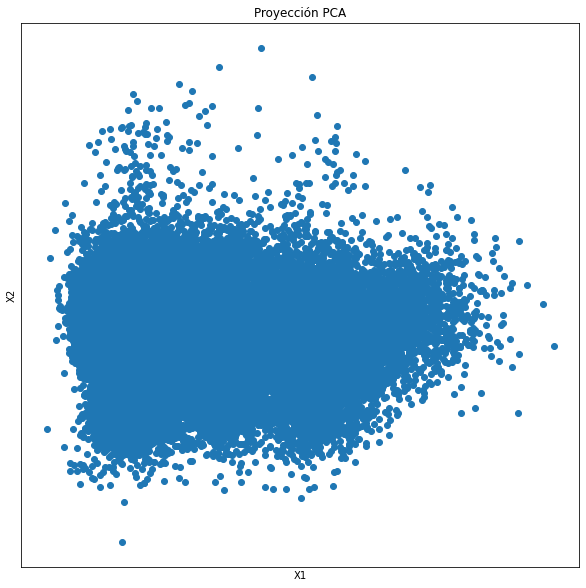

In [ ]:
X_pca = PCA(n_components=2, random_state=1337).fit_transform(final_X)

x_min, x_max = np.min(X_pca, 0), np.max(X_pca, 0)
X_pca = (X_pca - x_min) / (x_max - x_min)

plt.figure(figsize=(10,10))

plt.xlabel('X1')
plt.ylabel('X2')

plt.title('Proyección PCA')

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xticks([]), plt.yticks([])

plt.show()

### t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


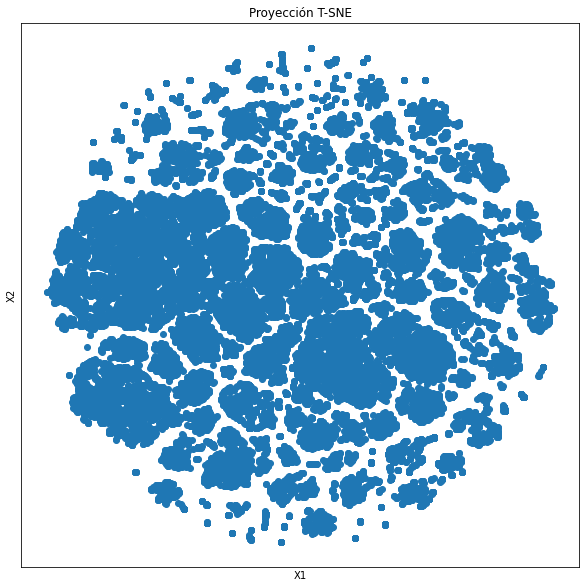

In [ ]:
plt.figure(figsize=(10,10))

plt.xlabel('X1')
plt.ylabel('X2')

plt.title('Proyección T-SNE')


tsne = TSNE(n_components=2, perplexity=10,random_state=1337,
            n_jobs=-1, init='pca', learning_rate='auto',
            n_iter=400)

X_tsne = tsne.fit_transform(final_X)

x_min, x_max = np.min(X_tsne, 0), np.max(X_tsne, 0)
X_tsne = (X_tsne - x_min) / (x_max - x_min)

plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.xticks([]), plt.yticks([])

plt.show()

### UMAP

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


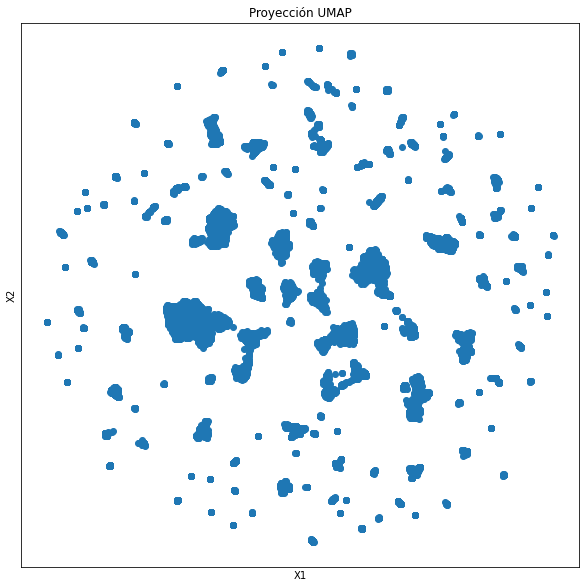

In [ ]:
umap = UMAP(n_components=2, random_state=1337)

X_umap = umap.fit_transform(final_X)

plt.figure(figsize=(10,10))

plt.xlabel('X1')
plt.ylabel('X2')

plt.title('Proyección UMAP')

plt.scatter(X_umap[:,0], X_umap[:,1])
plt.xticks([]), plt.yticks([])

plt.show()

**UMAP Hyperparameters**

As the previous dimensionality reduction algorithms, UMAP has a few hyperparameters that we can tune in order to get a better result such as the metric, the number of neighbours or the minimun distance.

euclidean 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


euclidean 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


euclidean 30


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


euclidean 50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


manhattan 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


manhattan 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


manhattan 30


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


manhattan 50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


cosine 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


cosine 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


cosine 30


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


cosine 50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


chebyshev 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


chebyshev 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


chebyshev 30


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


chebyshev 50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


minkowski 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


minkowski 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


minkowski 30


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


minkowski 50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


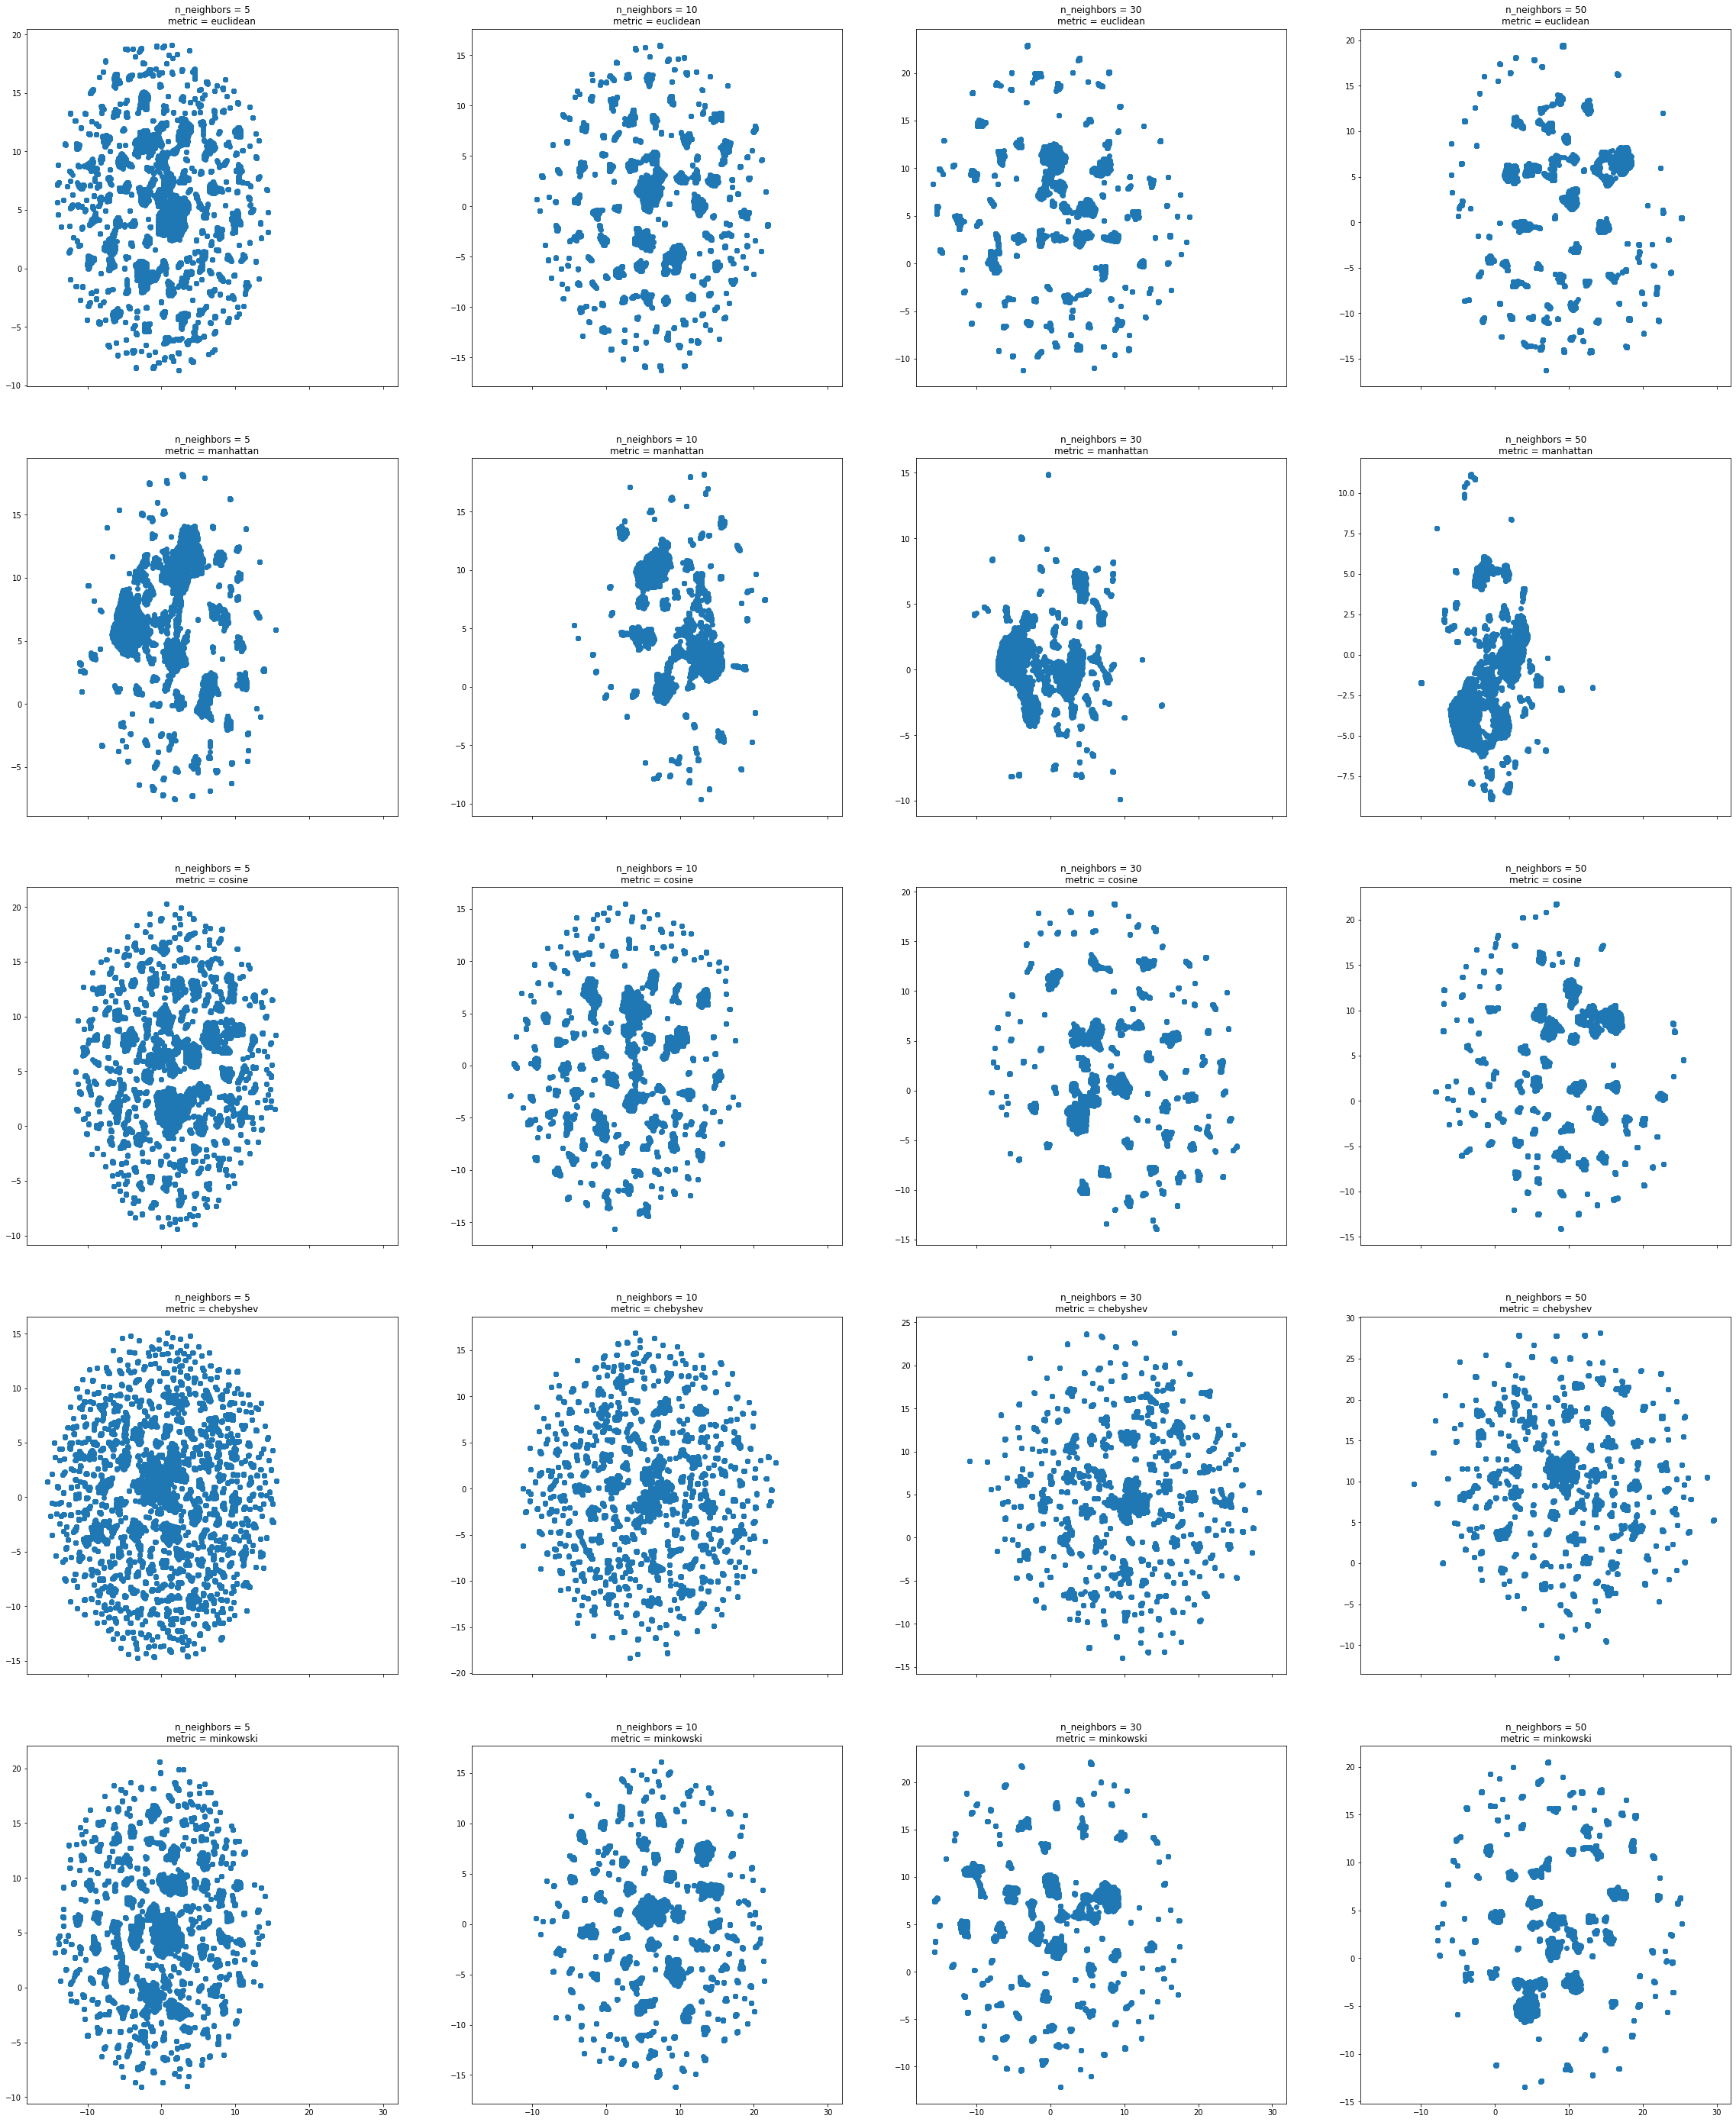

In [ ]:
f, axes = plt.subplots(nrows = 5, ncols = 4, sharex=True, figsize=[40,50])

for i, metric in enumerate(["euclidean", "manhattan","cosine", "chebyshev", "minkowski"]):
  for j, neighbor in enumerate([5, 10, 30, 50]):
    print(metric, neighbor)
    reducer = UMAP(n_neighbors=neighbor, metric=metric, n_components=2, random_state=1337)
    X_umap = reducer.fit_transform(final_X)

    axes[i][j].scatter(X_umap[:,0], X_umap[:,1])
    axes[i][j].set_title("n_neighbors = "+ str(neighbor) + "\nmetric = "+ str(metric))

Otro parámetro que afecta al resultado de UMAP es min_dist:

0.01


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



0.05


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



0.1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



0.25


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



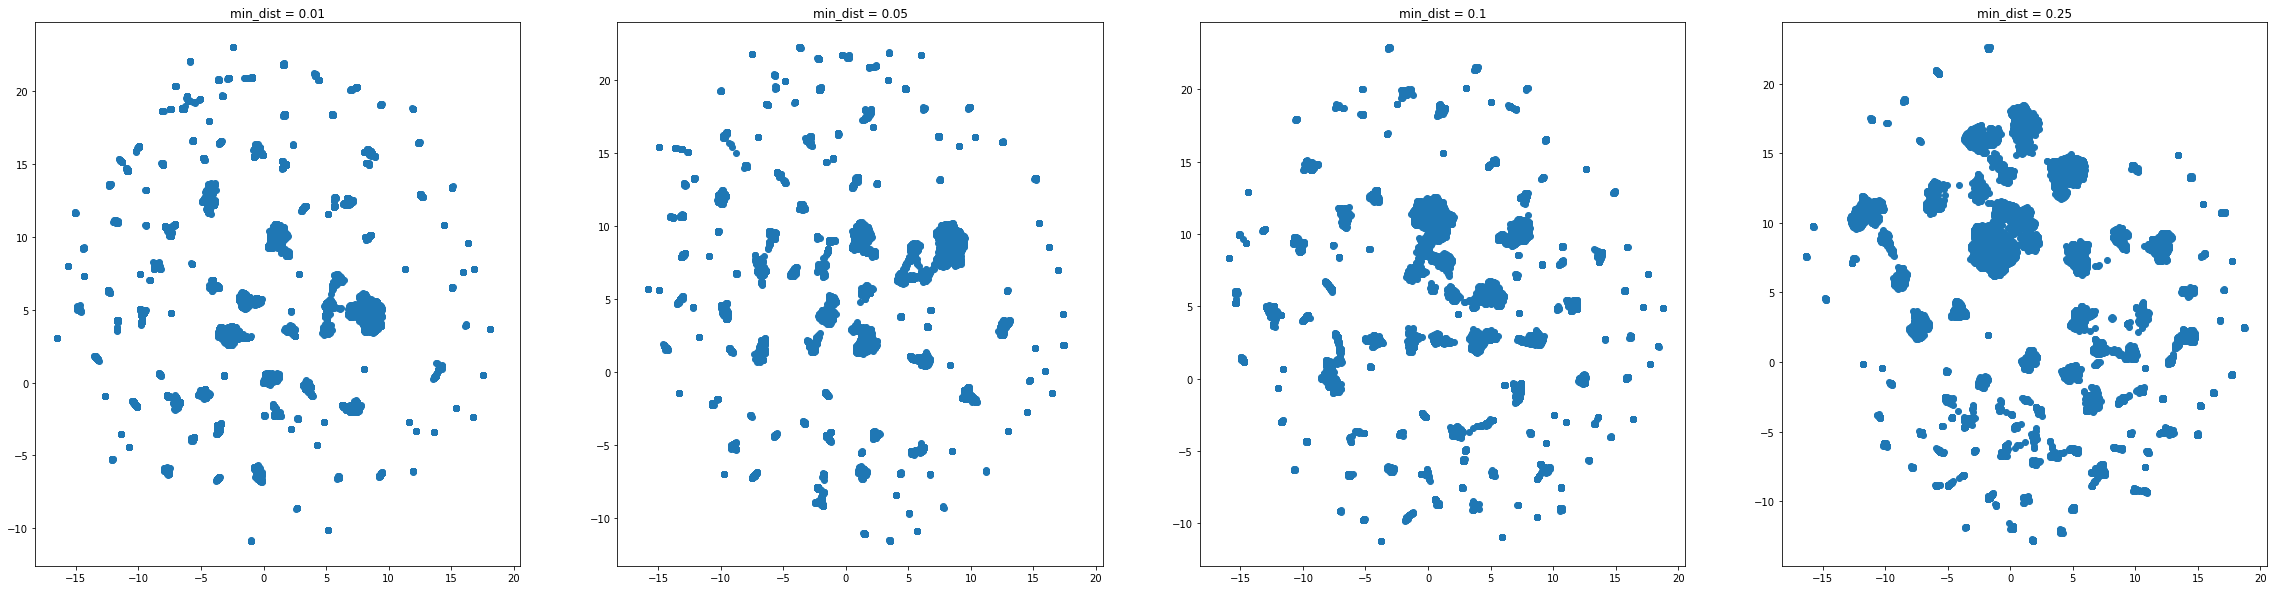

In [ ]:
f, axes = plt.subplots(nrows = 1, ncols = 4, sharex=True, figsize=[40,10])
for i, dist in enumerate([0.01, 0.05, 0.1, 0.25]):
    print(dist)
    reducer = UMAP(n_neighbors=30,min_dist=dist, metric='euclidean', n_components=2, random_state=1337)
    X_umap = reducer.fit_transform(final_X)
    axes[i].scatter(X_umap[:,0], X_umap[:,1])
    axes[i].set_title("min_dist = "+ str(dist))

We chose the following hyperparameters:

* n_neighbors = 30
* metric = euclidean
* min_dist = 0.25


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



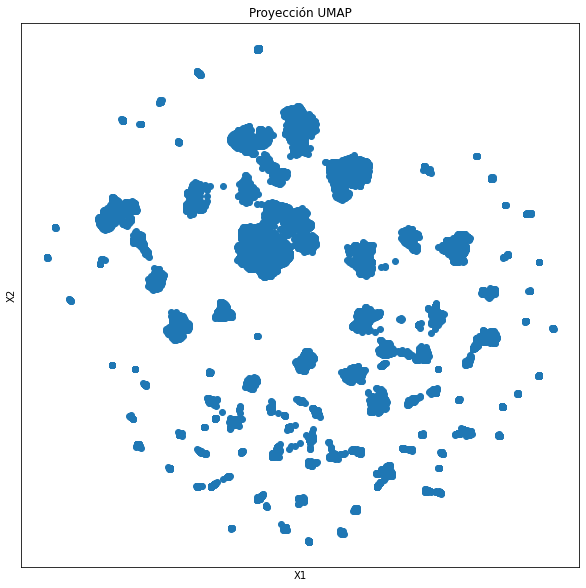

In [ ]:
reducer = UMAP(n_components= 2,n_neighbors= 30, metric= 'euclidean', min_dist=0.25, random_state= 1337)
X_reduced = reducer.fit_transform(final_X)

x_min, x_max = np.min(X_reduced, 0), np.max(X_reduced, 0)
X_reduced = (X_reduced - x_min) / (x_max - x_min)

plt.figure(figsize=(10,10))

plt.xlabel('X1')
plt.ylabel('X2')

plt.title('Proyección UMAP')

plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.xticks([]), plt.yticks([])

plt.show()

We can also visualize the dataset in 3D:

In [ ]:
reducer3d = UMAP(n_components= 3,n_neighbors= 30, metric= 'euclidean', min_dist=0.25, random_state= 1337)
X_reduced_3d = reducer3d.fit_transform(final_X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [ ]:
fig = px.scatter_3d(X_reduced_3d, x=0,y=1,z=2, 
                    size_max=5, color=final_X[0], color_continuous_scale ='bluered')
fig.show()

In [ ]:
# pd.DataFrame(X_reduced).to_csv('reduced_dataset.csv', index=False)

In [ ]:
# Load reduced dataset
# url = 'https://drive.google.com/file/d/10fr_0HVLVCTFpA7qb_vcSZhjd6bJrD0w/view?usp=sharing'
# url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
# reduced_dataset = 'reduced_dataset.csv'
# gdown.download(url2,reduced_dataset, quiet=True)
# X_reduced = pd.read_csv(reduced_dataset).to_numpy()
# X_reduced

## Clustering training

There are multiple clustering algorithms. Some of them don't scale well with the amount of data as we can see in this [image](https://i.stack.imgur.com/Yl4tV.png) using a lot of memory. 

In this part we are going to train different models and look for the best set of hyperparameters with GridSearch.

In the last part we will compare the results.

In [ ]:
training_results = pd.DataFrame(columns=["Model", "Clusters", "Silhouette"])
training_results

Empty DataFrame
Columns: [Model, Clusters, Silhouette]
Index: []

### K-Means

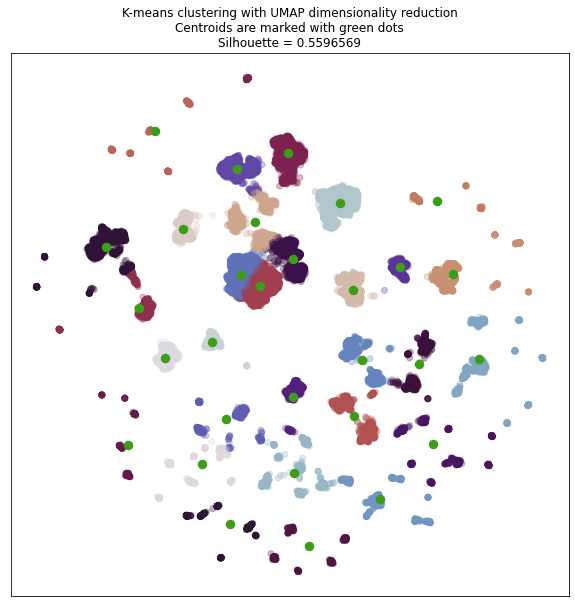

In [ ]:
kmeans = KMeans(n_clusters=30, random_state=1337).fit(X_reduced)
kmeans_labels = kmeans.predict(X_reduced)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, alpha=0.3, cmap='twilight_shifted')
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="o",
    color="#3C9E17",
    zorder=3,
    s=20,
    linewidths=5
)
silhouette = silhouette_score(X_reduced, kmeans_labels, metric='euclidean')

plt.title(
    "K-means clustering with UMAP dimensionality reduction\n"
    "Centroids are marked with green dots\n"
    "Silhouette = " +  str(silhouette)
)

plt.xticks(())
plt.yticks(())
plt.show()

#### GridSearch Hyperparameter tunning

In [ ]:
def cv_silhouette_scorer(estimator, X): # Definimos la función de silhouette
    estimator.fit(X)
    cluster_labels = estimator.labels_
    score = silhouette_score(X, cluster_labels, metric='euclidean')
    return score

cv = [(slice(None), slice(None))] # Con esta lista evitamos cross-validation


In [ ]:
kmeans = KMeans(random_state=1337)
param_dict={'n_clusters':range(30,100,10)}
gs = GridSearchCV(estimator=kmeans, param_grid=param_dict, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)
gs.fit(X_reduced)

print("Optimal hyperparameter combination:", gs.best_params_)

Optimal hyperparameter combination: {'n_clusters': 80}


We get the following results with Grid Search.

In [ ]:
gs.cv_results_

{'mean_fit_time': array([ 3.74076867,  4.81551194,  7.1597724 ,  8.70646143, 10.29888105,
        11.38887286, 11.06398582]),
 'mean_score_time': array([87.26212168, 87.62409854, 89.62266898, 91.26382637, 93.66452026,
        96.02088141, 69.06055403]),
 'mean_test_score': array([0.55965692, 0.60618412, 0.61257094, 0.60959554, 0.61655098,
        0.63285196, 0.62624753]),
 'param_n_clusters': masked_array(data=[30, 40, 50, 60, 70, 80, 90],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_clusters': 30},
  {'n_clusters': 40},
  {'n_clusters': 50},
  {'n_clusters': 60},
  {'n_clusters': 70},
  {'n_clusters': 80},
  {'n_clusters': 90}],
 'rank_test_score': array([7, 6, 4, 5, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.55965692, 0.60618412, 0.61257094, 0.60959554, 0.61655098,
        0.63285196, 0.62624753]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0.]),
 'std_score_time': array([0.,

We can show the best result

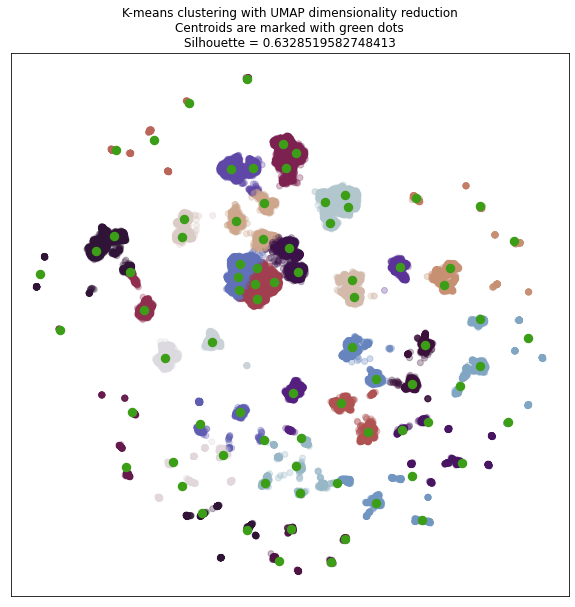

In [ ]:
best_kmeans = gs.best_estimator_
best_kmeans.fit(X_reduced)
best_kmeans_labels = best_kmeans.predict(X_reduced)
centroids = best_kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, alpha=0.3, cmap='twilight_shifted')
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="o",
    color="#3C9E17",
    zorder=3,
    s=20,
    linewidths=5
)
kmeans_silhouette = gs.best_score_

plt.title(
    "K-means clustering with UMAP dimensionality reduction\n"
    "Centroids are marked with green dots\n"
    "Silhouette = " +  str(kmeans_silhouette)
)

plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
kmeans_row =pd.Series({"Model":"K-Means", "Clusters":80, "Silhouette":0.63285196})
training_results= training_results.append(kmeans_row, ignore_index=True)

### HDBSCAN

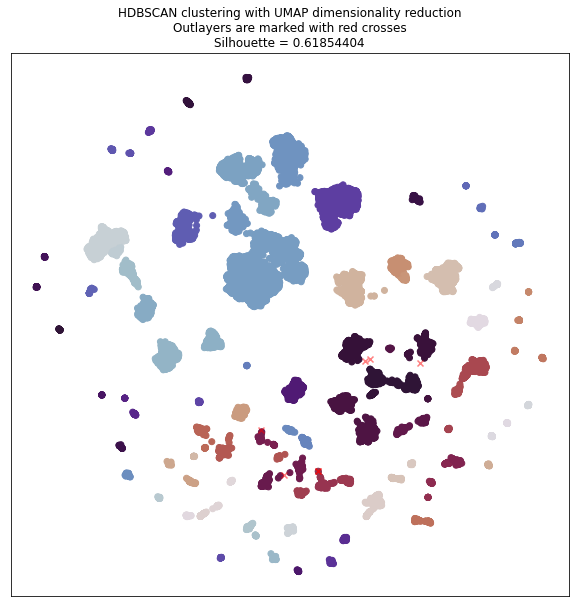

In [ ]:
hdbscan = HDBSCAN(cluster_selection_epsilon=0.01, metric='euclidean').fit(X_reduced)

data = np.concatenate((X_reduced, hdbscan.labels_.reshape(-1, 1)), axis=1)
samples = data[data[:,2] != -1]
outlayers = data[data[:,2] == -1]


plt.figure(figsize=(10,10))
plt.scatter(samples[:,0], samples[:,1], c=samples[:,2], cmap='twilight_shifted')
plt.scatter(outlayers[:,0], outlayers[:,1], c='red', marker='x', alpha=0.5)

silhouette = silhouette_score(X_reduced, hdbscan.labels_,metric='euclidean')

plt.title(
    "HDBSCAN clustering with UMAP dimensionality reduction\n"
    "Outlayers are marked with red crosses\n"
    "Silhouette = " +  str(silhouette)

)

plt.xticks(())
plt.yticks(())
plt.show()

#### GridSearch Hyperparameter tunning

In [ ]:
hdbscan = HDBSCAN(metric="euclidean")

param_dict={'min_cluster_size':[100,200,300,400,500,600],
            'min_samples':[10,30,50,60,100]}

gs = GridSearchCV(estimator=hdbscan, param_grid=param_dict, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1, verbose=10)
gs.fit(X_reduced)

print("Optimal hyperparameter combination:", gs.best_params_)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Optimal hyperparameter combination: {'min_cluster_size': 200, 'min_samples': 60}


In [ ]:
gs.cv_results_

{'mean_fit_time': array([2.78268886, 3.11168146, 3.31758285, 3.47286844, 3.989012  ,
        2.77239299, 3.06863332, 3.3443861 , 3.41803241, 4.00984526,
        2.73119855, 3.16822553, 3.36411619, 3.48843217, 4.10432315,
        2.71638346, 3.04064536, 3.37833524, 3.50954938, 4.11627984,
        2.6043632 , 3.01003528, 3.46820307, 3.67888522, 4.07152557,
        2.68542886, 3.07328653, 3.35410619, 3.60527372, 4.03094292]),
 'mean_score_time': array([86.20991492, 86.98620152, 87.41005754, 87.30895495, 88.1405127 ,
        86.52307153, 87.03451061, 86.73846197, 87.3594985 , 86.74814081,
        86.27697849, 85.92883277, 87.02185249, 86.80783606, 87.25203896,
        86.06737924, 87.45221782, 87.26267815, 90.19966269, 92.47683668,
        87.18969274, 86.62250733, 87.46765995, 87.54820013, 88.33647037,
        86.76999044, 87.87196422, 87.59866691, 91.08806229, 90.33539748]),
 'mean_test_score': array([0.52236539, 0.52635825, 0.52237999, 0.54257888, 0.51123923,
        0.53131574, 0.53706

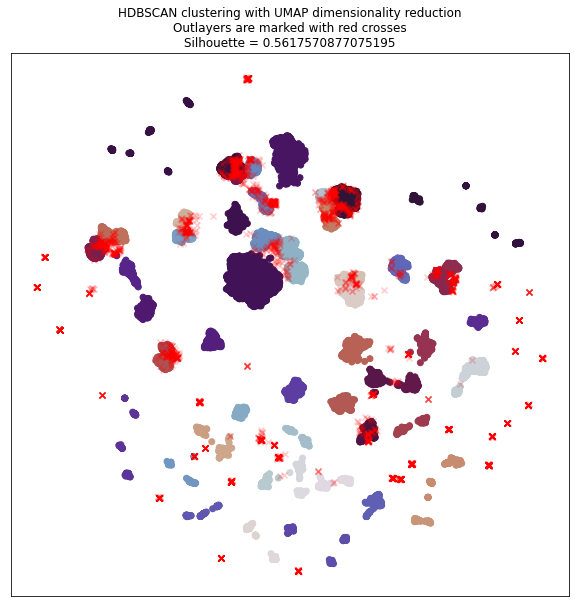

In [ ]:
best_hdbscan = gs.best_estimator_
best_hdbscan.fit(X_reduced)

data = np.concatenate((X_reduced, best_hdbscan.labels_.reshape(-1, 1)), axis=1)
samples = data[data[:,2] != -1]
outlayers = data[data[:,2] == -1]


plt.figure(figsize=(10,10))
plt.scatter(samples[:,0], samples[:,1], c=samples[:,2], cmap='twilight_shifted')
plt.scatter(outlayers[:,0], outlayers[:,1], c='red', marker='x', alpha=0.2)

hdbscan_silhouette = gs.best_score_

plt.title(
    "HDBSCAN clustering with UMAP dimensionality reduction\n"
    "Outlayers are marked with red crosses\n"
    "Silhouette = " +  str(hdbscan_silhouette)

)

plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
hdbscan_row =pd.Series({"Model":"HDBSCAN", "Clusters":72,"Silhouette":0.561757})
training_results = training_results.append(hdbscan_row, ignore_index=True)

### Birch

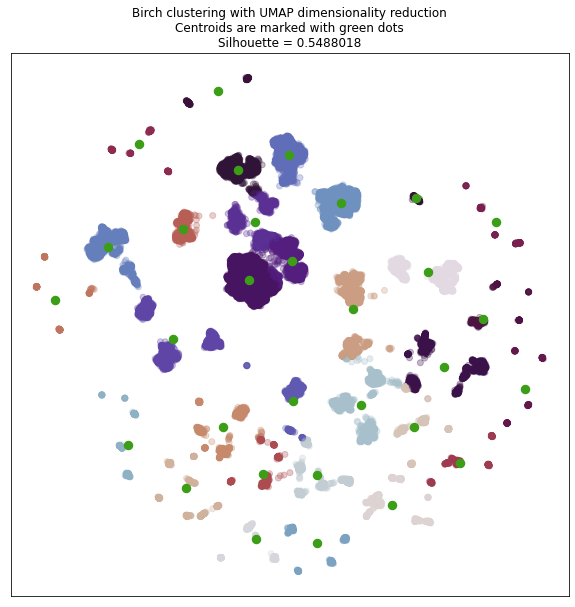

In [ ]:
birch = Birch(n_clusters=None, threshold=0.07)

birch.fit(X_reduced)
birch_labels = birch.predict(X_reduced)
birch_centroids = birch.subcluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=birch_labels, alpha=0.3, cmap='twilight_shifted')
plt.scatter(
    birch_centroids[:, 0],
    birch_centroids[:, 1],
    marker="o",
    color="#3C9E17",
    zorder=3,
    s=20,
    linewidths=5
)
birch_silhouette = silhouette_score(X_reduced, birch_labels, metric='euclidean')

plt.title(
    "Birch clustering with UMAP dimensionality reduction\n"
    "Centroids are marked with green dots\n"
    "Silhouette = " +  str(birch_silhouette)
)

plt.xticks(())
plt.yticks(())
plt.show()

#### GridSearch Hyperparameter tunning

In [ ]:
birch = Birch(n_clusters=None)

param_dict = {'threshold':[0.05, 0.075, 0.1, 0.25, 0.5]}

gs = GridSearchCV(estimator=birch, param_grid=param_dict, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1, verbose=10)
gs.fit(X_reduced)

print("Optimal hyperparameter combination:", gs.best_params_)

Fitting 1 folds for each of 5 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning:

One or more of the test scores are non-finite: [0.62349409 0.51064628 0.48481485 0.44914731        nan]



Optimal hyperparameter combination: {'threshold': 0.05}


In [ ]:
gs.cv_results_

{'mean_fit_time': array([3.14348173, 3.14690471, 3.02241373, 3.01468182, 2.43989921]),
 'mean_score_time': array([87.43010497, 88.85494637, 88.36646366, 88.72970796,  1.46470857]),
 'mean_test_score': array([0.62349409, 0.51064628, 0.48481485, 0.44914731,        nan]),
 'param_threshold': masked_array(data=[0.05, 0.075, 0.1, 0.25, 0.5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'threshold': 0.05},
  {'threshold': 0.075},
  {'threshold': 0.1},
  {'threshold': 0.25},
  {'threshold': 0.5}],
 'rank_test_score': array([1, 2, 3, 4, 5], dtype=int32),
 'split0_test_score': array([0.62349409, 0.51064628, 0.48481485, 0.44914731,        nan]),
 'std_fit_time': array([0., 0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'std_test_score': array([ 0.,  0.,  0.,  0., nan])}

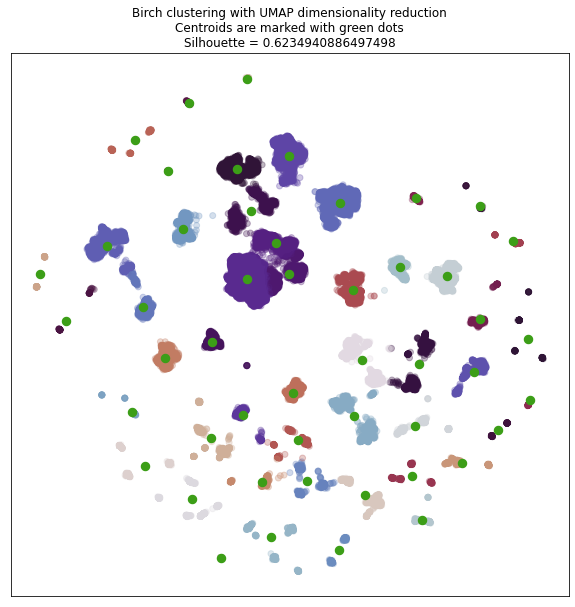

In [ ]:
best_birch = gs.best_estimator_
best_birch.fit(X_reduced)

best_birch_labels = best_birch.predict(X_reduced)
best_birch_centroids = best_birch.subcluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=best_birch_labels, alpha=0.3, cmap='twilight_shifted')
plt.scatter(
    best_birch_centroids[:, 0],
    best_birch_centroids[:, 1],
    marker="o",
    color="#3C9E17",
    zorder=3,
    s=20,
    linewidths=5
)
best_birch_silhouette = gs.best_score_

plt.title(
    "Birch clustering with UMAP dimensionality reduction\n"
    "Centroids are marked with green dots\n"
    "Silhouette = " +  str(best_birch_silhouette)
)

plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
birch_row = pd.Series({"Model":"Birch", "Clusters":len(set(gs.best_estimator_.labels_)), "Silhouette":best_birch_silhouette})
training_results= training_results.append(birch_row, ignore_index=True)

### Agglomerative Clustering

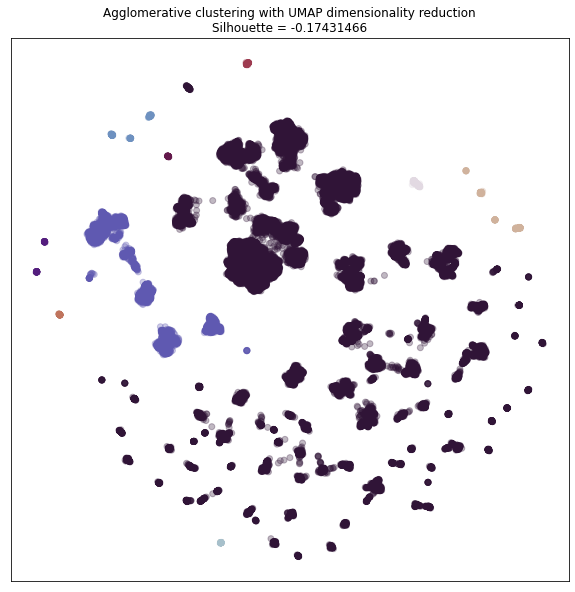

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=0.07, linkage='single').fit(X_reduced)
agglomerative_labels = agglomerative.labels_

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=agglomerative_labels, alpha=0.3, cmap='twilight_shifted')

agglomerative_silhouette = silhouette_score(X_reduced, agglomerative_labels, metric='euclidean')

plt.title(
    "Agglomerative clustering with UMAP dimensionality reduction\n"
    "Silhouette = " +  str(agglomerative_silhouette)

)

plt.xticks(())
plt.yticks(())
plt.show()

#### GridSearch Hyperparameter tunning

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=None, linkage='single')

param_dict = {'distance_threshold':[0.01, 0.025, 0.05, 0.075, 0.1]}

gs = GridSearchCV(estimator=agglomerative, param_grid=param_dict, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1, verbose=10)
gs.fit(X_reduced)

print("Optimal hyperparameter combination:", gs.best_params_)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
Optimal hyperparameter combination: {'distance_threshold': 0.01}


In [ ]:
gs.cv_results_

{'mean_fit_time': array([39.07419801, 39.00851226, 39.19230413, 39.02668071, 25.1680634 ]),
 'mean_score_time': array([136.43389964, 136.98957586, 126.48638415, 128.13560772,
         94.18343282]),
 'mean_test_score': array([ 0.56061667,  0.49445927,  0.13286552, -0.11037046,  0.21484599]),
 'param_distance_threshold': masked_array(data=[0.01, 0.025, 0.05, 0.075, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'distance_threshold': 0.01},
  {'distance_threshold': 0.025},
  {'distance_threshold': 0.05},
  {'distance_threshold': 0.075},
  {'distance_threshold': 0.1}],
 'rank_test_score': array([1, 2, 4, 5, 3], dtype=int32),
 'split0_test_score': array([ 0.56061667,  0.49445927,  0.13286552, -0.11037046,  0.21484599]),
 'std_fit_time': array([0., 0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'std_test_score': array([0., 0., 0., 0., 0.])}

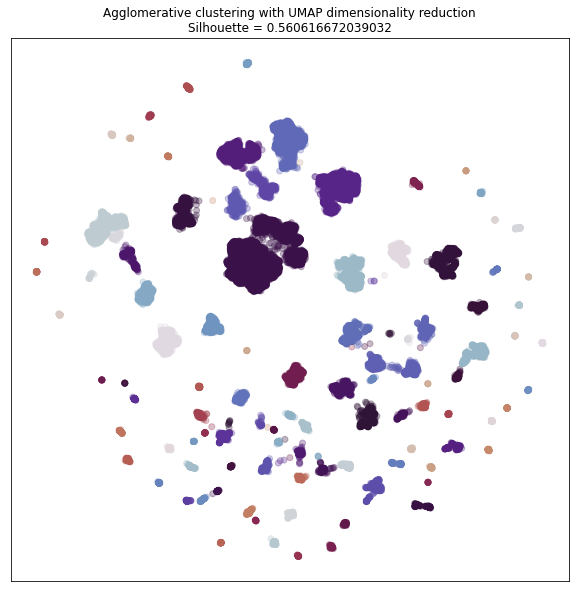

In [ ]:
best_agglomerative = gs.best_estimator_
best_agglomerative_labels = best_agglomerative.labels_

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=best_agglomerative_labels, alpha=0.3, cmap='twilight_shifted')

best_agglomerative_silhouette = gs.best_score_
plt.title(
    "Agglomerative clustering with UMAP dimensionality reduction\n"
    "Silhouette = " +  str(best_agglomerative_silhouette)

)

plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
agglomerative_row = pd.Series({"Model":"Agglomerative Clustering", "Clusters":len(set(gs.best_estimator_.labels_)), "Silhouette":best_agglomerative_silhouette})
training_results= training_results.append(agglomerative_row, ignore_index=True)

### Spectral Clustering

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



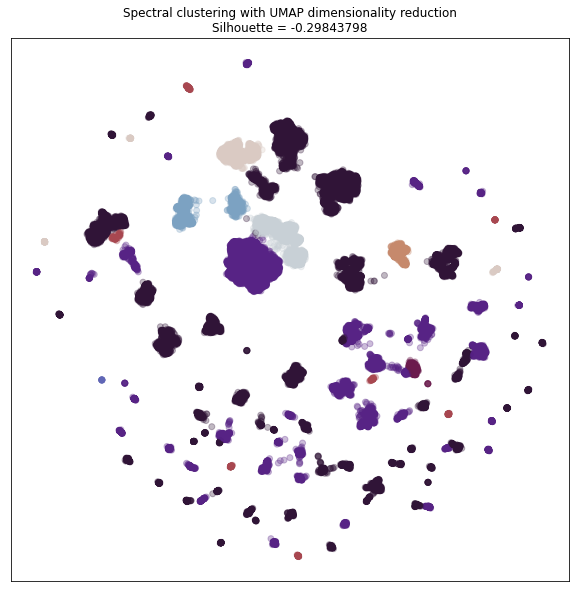

In [ ]:
spectral_clustering = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', n_jobs=-1, random_state=1337).fit(X_reduced)
plt.figure(figsize=(10,10))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=spectral_clustering.labels_, alpha=0.3, cmap='twilight_shifted')
silhouette = silhouette_score(X_reduced, spectral_clustering.labels_, metric='euclidean')

plt.title("Spectral clustering with UMAP dimensionality reduction\n"
          "Silhouette = " +  str(silhouette))

plt.xticks(())
plt.yticks(())
plt.show()

#### GridSearch Hyperparameter tunning

In [ ]:
spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_jobs=-1, random_state=1337)

param_dict = {'n_clusters':[30, 40, 50],
              'n_neighbors': [30,40]}

gs = GridSearchCV(estimator=spectral_clustering, param_grid=param_dict, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1, verbose=10)
gs.fit(X_reduced)

print("Optimal hyperparameter combination:", gs.best_params_)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Optimal hyperparameter combination: {'n_clusters': 40, 'n_neighbors': 40}


In [ ]:
gs.cv_results_

{'mean_fit_time': array([389.46113086, 367.23217463, 342.6631422 , 434.05438042,
        284.15941501, 356.23868585]),
 'mean_score_time': array([481.37001753, 459.86298966, 603.42023754, 512.98417449,
        380.06851006, 414.493258  ]),
 'mean_test_score': array([0.05856213, 0.076245  , 0.13306789, 0.16059282, 0.121364  ,
        0.15486303]),
 'param_n_clusters': masked_array(data=[30, 30, 40, 40, 50, 50],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_neighbors': masked_array(data=[30, 40, 30, 40, 30, 40],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_clusters': 30, 'n_neighbors': 30},
  {'n_clusters': 30, 'n_neighbors': 40},
  {'n_clusters': 40, 'n_neighbors': 30},
  {'n_clusters': 40, 'n_neighbors': 40},
  {'n_clusters': 50, 'n_neighbors': 30},
  {'n_clusters': 50, 'n_neighbors': 40}],
 'rank_test_score': array([6, 5, 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



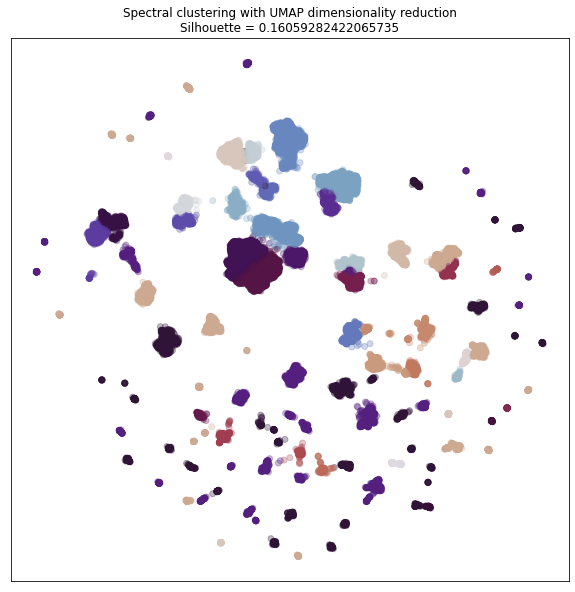

In [ ]:
best_spectral_clustering = gs.best_estimator_
best_spectral_clustering.fit(X_reduced)

best_spectral_clustering_labels = best_spectral_clustering.labels_

best_spectral_clustering_silhouette = gs.best_score_

plt.figure(figsize=(10,10))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=best_spectral_clustering_labels, alpha=0.3, cmap='twilight_shifted')
plt.title("Spectral clustering with UMAP dimensionality reduction\n"
          "Silhouette = " +  str(best_spectral_clustering_silhouette))

plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
spectral_row = pd.Series({"Model":"Spectral Clustering", "Clusters":len(set(gs.best_estimator_.labels_)),"Silhouette":best_spectral_clustering_silhouette})
training_results= training_results.append(spectral_row, ignore_index=True)

## Model Comparison



In [ ]:
training_results = training_results.sort_values(by='Silhouette', ascending=False)

In [ ]:
training_results

Model Clusters  Silhouette
1                   K-Means       80    0.632852
2                     Birch       49    0.623494
0                   HDBSCAN       72    0.561757
3  Agglomerative Clustering      115    0.560617
4       Spectral Clustering       40    0.160593

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



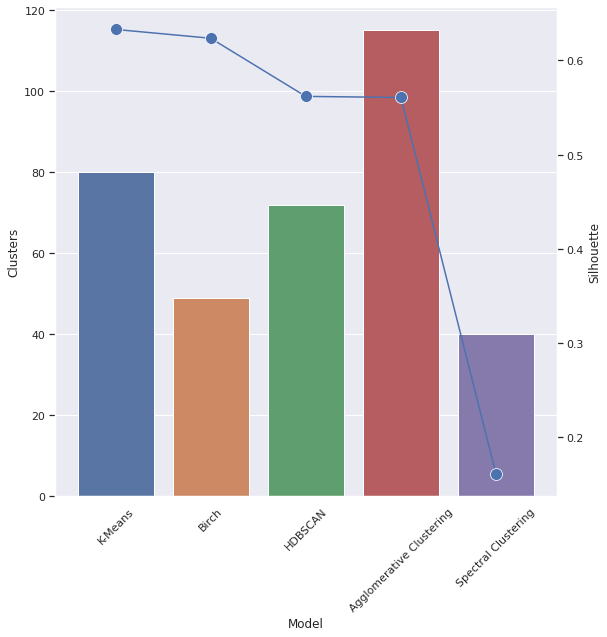

In [ ]:
sns.set_theme()

fig = plt.figure(figsize = (9,9))
plt.xticks(rotation=45)

ax1 = fig.add_subplot(111)
ax1 = sns.barplot(data=training_results, x='Model', y='Clusters')
ax2 = ax1.twinx()
ax2 = (sns.lineplot(data=training_results, x='Model', y='Silhouette', marker='o', markersize=12))
ax2.grid(False)

plt.show()

As we can see, all the models provide a number of clusters bigger than 40 and the silhouette value is better for K-Means and Birch in this case.

We can highlight that a bigger number of clusters doesn't mean that the silhouette score is better as we can see with the agglomerative model.

---

Created by **Roberto Mancebo Martín**

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">